Import libraries

In [1]:
import numpy as np
from pyscf import gto
from openfermion import FermionOperator as FO
from pyscf import scf
from IPython.display import Image
from openfermionpyscf import run_pyscf
from openfermion import MolecularData, get_fermion_operator
from openfermion import QubitOperator as ofQubitOperator
from openfermion.transforms import jordan_wigner
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit import QuantumCircuit
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.quantum_info import Statevector
from qiskit.visualization import plot_histogram
from qiskit_ibm_runtime import SamplerV2 as Sampler
from qiskit_aer import AerSimulator
import matplotlib.pyplot as plt
from qiskit.quantum_info import Statevector

# Part I
## Conventional quantum chemistry

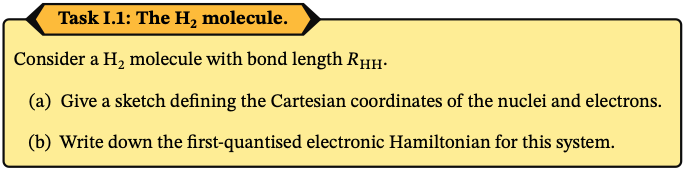

In [2]:
Image('1_1.png')

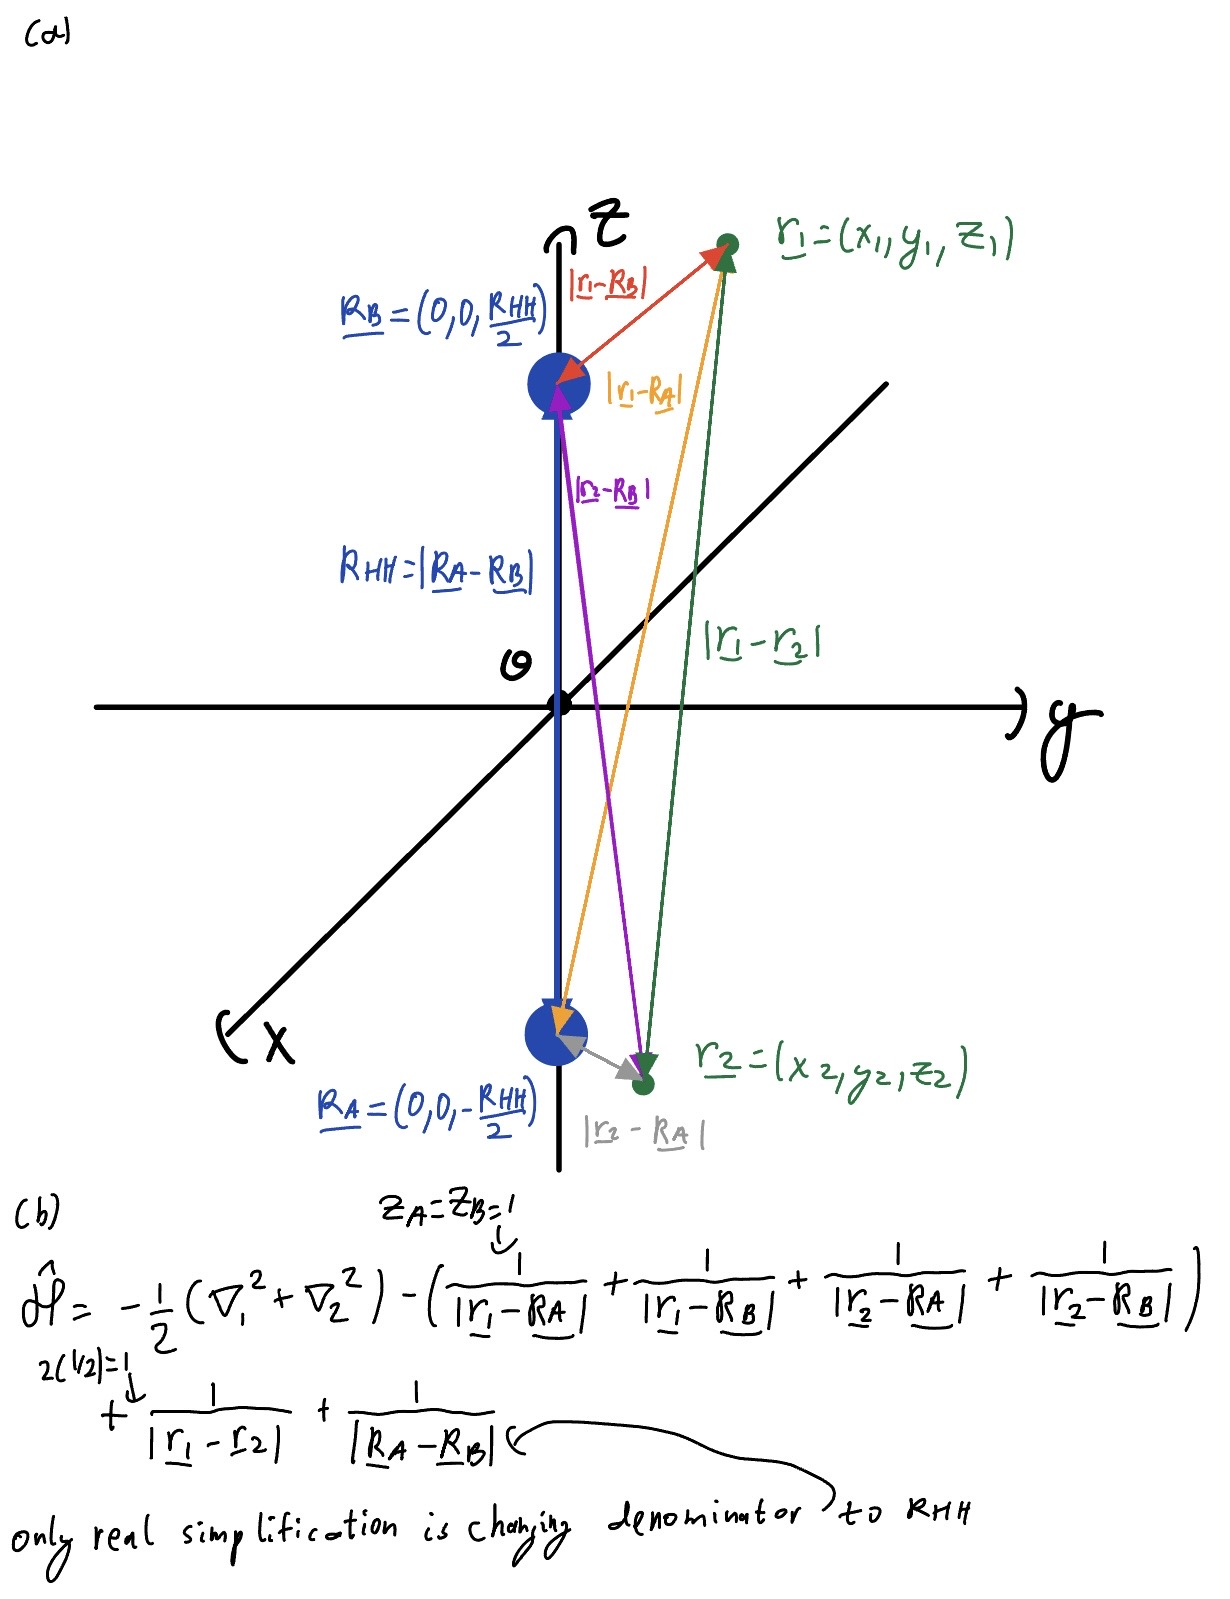

In [3]:
Image('1_1_a.jpg')

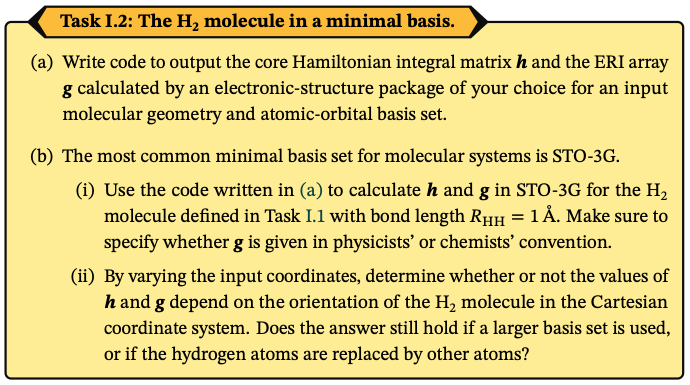

In [4]:
Image('1_2.png')

**(a)**

In [5]:
def core_and_eri(atom,basis="sto-3g",unit="Angstrom",charge= 0,spin=0):
    
    mol = gto.Mole()
    mol.atom = atom
    mol.unit = unit
    mol.basis = basis
    mol.charge = charge 
    mol.spin = spin
    mol.build()

    # Core Hamiltonian
    h = mol.intor("int1e_kin") + mol.intor("int1e_nuc") #one electron AO integrals

    # PySCF defaults to chemists' notation
    g = mol.intor("int2e")
    v = mol.energy_nuc()#needed later
    return h,g,v

**(b)**

**(i)**

STO-3G is a minimal basis set where each basis function is a contracted Gaussian made from three Gaussians, fitted to approximate a Slater type orbital. In a minimal basis, one contracted function is used for each occupied atomic orbital of the free atom [1]. For H each atom has only 1s occupied, so you get one contracted 1s function per H.

PySCF has $g_{\mu\mu'\nu\nu'}=(\mu\mu'|\nu\nu')$ [2].

In [6]:
atom = """
H 0. 0. 0.
H 0. 0. 1.
"""
# first is H at origin, second is H at (0,0,1)

print("Chemists convention")
h,g,v=core_and_eri(atom=atom)
print("\nh =",h)
print("g =",g)

Chemists convention

h = [[-0.97949638 -0.68286493]
 [-0.68286493 -0.97949638]]
g = [[[[0.77460594 0.30930897]
   [0.30930897 0.47804137]]

  [[0.30930897 0.15786578]
   [0.15786578 0.30930897]]]


 [[[0.30930897 0.15786578]
   [0.15786578 0.30930897]]

  [[0.47804137 0.30930897]
   [0.30930897 0.77460594]]]]


One electron energy in AO 1s on each H.
$$
h_{11}=( 1|\hat h|1)_\mathbf{r}
=-0.9794963769
$$

Coupling between the two AOs. 
$$
h_{12}=( 1|\hat h|2)_\mathbf{r}
=-0.6828649331
$$

Coulomb repulsion for two electrons in AO 1 (opposite spins).
$$
g_{1111}=(11|11)_{\mathbf{r}_1\mathbf{r}_2}=0.7746059439
$$

Coulomb repulsion between the overlap densities.
$$
g_{1212}=(12|12)_{\mathbf{r}_1\mathbf{r}_2}=0.1578657779
$$

Coulomb interaction between densities on different atoms.
$$
g_{1122}=(11|22)_{\mathbf{r}_1\mathbf{r}_2}=0.4780413732
$$

Exchange interaction.
$$
g_{1221}=(12|21)_{\mathbf{r}_1\mathbf{r}_2}=0.1578657779
$$

Repulsion between the density on atom 1 and the overlap density.
$$
g_{1112}=(11|12)_{\mathbf{r}_1\mathbf{r}_2}=0.3093089672
$$

**(ii)**

1. Along $z-$axis, centre at origin.

In [7]:
atom = """
H 0.000000 0.000000 -0.500000
H 0.000000 0.000000 0.500000
"""

h,g,v=core_and_eri(atom=atom)
print("h =",h)
print("g =",g)


h = [[-0.97949638 -0.68286493]
 [-0.68286493 -0.97949638]]
g = [[[[0.77460594 0.30930897]
   [0.30930897 0.47804137]]

  [[0.30930897 0.15786578]
   [0.15786578 0.30930897]]]


 [[[0.30930897 0.15786578]
   [0.15786578 0.30930897]]

  [[0.47804137 0.30930897]
   [0.30930897 0.77460594]]]]


Along $y-$axis, with $z=1$.

In [8]:
atom = """
H 0.000000 1.000000 1.000000
H 0.000000 0.000000 1.000000
"""
h,g,v=core_and_eri(atom=atom)
print("h =",h)
print("g =",g)


h = [[-0.97949638 -0.68286493]
 [-0.68286493 -0.97949638]]
g = [[[[0.77460594 0.30930897]
   [0.30930897 0.47804137]]

  [[0.30930897 0.15786578]
   [0.15786578 0.30930897]]]


 [[[0.30930897 0.15786578]
   [0.15786578 0.30930897]]

  [[0.47804137 0.30930897]
   [0.30930897 0.77460594]]]]


$45$ degrees in the $xy-$plane.

In [9]:
atom = """
H -0.353553 -0.353553 0.000000
H  0.353553  0.353553 0.000000
"""
h,g,v=core_and_eri(atom=atom)
print("h =",h)
print("g =",g)

h = [[-0.97949687 -0.68286598]
 [-0.68286598 -0.97949687]]
g = [[[[0.77460594 0.30930948]
   [0.30930948 0.47804173]]

  [[0.30930948 0.15786624]
   [0.15786624 0.30930948]]]


 [[[0.30930948 0.15786624]
   [0.15786624 0.30930948]]

  [[0.47804173 0.30930948]
   [0.30930948 0.77460594]]]]


Along $(1,1,1)$ direction

In [10]:
atom = """
H -0.288675 -0.288675 -0.288675
H  0.288675  0.288675  0.288675
"""
h,g,v=core_and_eri(atom=atom)
print("h =",h)
print("g =",g)

h = [[-0.97949659 -0.68286537]
 [-0.68286537 -0.97949659]]
g = [[[[0.77460594 0.30930918]
   [0.30930918 0.47804153]]

  [[0.30930918 0.15786597]
   [0.15786597 0.30930918]]]


 [[[0.30930918 0.15786597]
   [0.15786597 0.30930918]]

  [[0.47804153 0.30930918]
   [0.30930918 0.77460594]]]]


The values of $\mathbf{h}$ and $\mathbf{g}$ are unchanged under rigid rotations of the $H_2$ molecule, so they do not depend on its orientation in the Cartesian frame. In general, these integrals depend only on the internal geometry, not on absolute orientation, but for basis functions with $l>0$ a rotated molecule corresponds to a rotated AO basis.

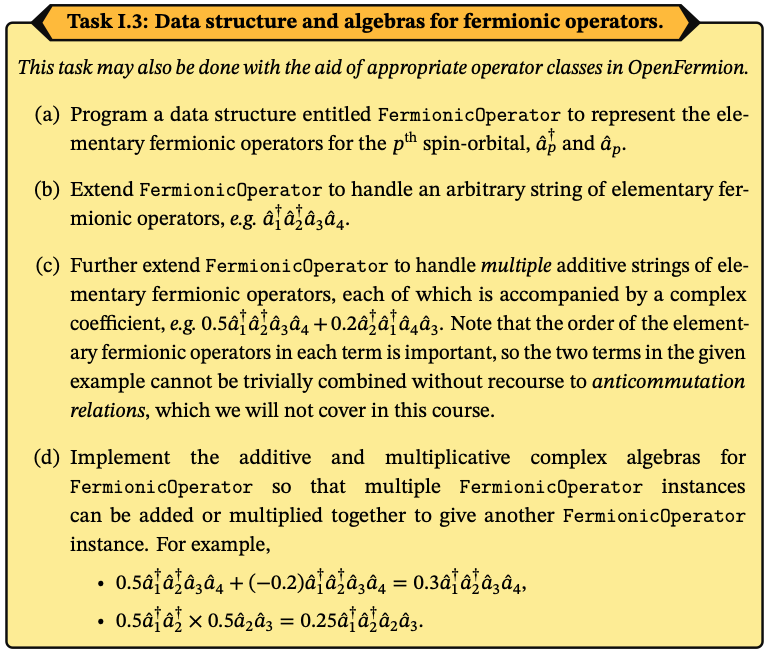

In [11]:
Image('1_3.png')

In [12]:
class FermionicOperator:
    def __init__(self, _of=None):
        self._of = _of if _of is not None else FO() 
#stores operator, if empty allows zero operator
    
#(a)
    @staticmethod #(does not use self)
    def create(i):
        return FermionicOperator(FO(((int(i), 1),), 1.0)) #create at site i (coeff of 1)
#((int(i), 1),) is a one-element tuple holding (int(i), 1)  
    @staticmethod
    def destroy(i):
        return FermionicOperator(FO(((int(i), 0),), 1.0))
        
#(b)
    @staticmethod
    def string(ops, coeff=1.0):
        term = tuple((int(i),ca) for i, ca in ops)
#ops is an ordered list of (i, ca), ca is create/annihilate (1 or 0 respectively)
        return FermionicOperator(FO(term, complex(coeff)))

#(c)
    @staticmethod
    def sum(terms):
        of = FO()
        for coeff, ops in terms:
            of += FermionicOperator.string(ops, coeff)._of #unwraps to get FO
        return FermionicOperator(of)
#(d)
# __add__ adds two FO objects,
    def __add__(self, other):
        return FermionicOperator(self._of + other._of)

    def __mul__(self, other):
        if isinstance(other, FermionicOperator):
# if other is a fermionic operator, do operator multiplication, otherwise do scalar multiplication
            return FermionicOperator(self._of * other._of)
        return FermionicOperator(self._of * complex(other))

    def __rmul__(self, other):
        return FermionicOperator(complex(other) * self._of)

    def __str__(self):
        #useful for II.3 part (d), prints string of object
        return str(self._of)
    

    
    def to_openfermion(self):
        return self._of
#returns operator

Sum and Add do the same thing in slightly different ways which is shown below, Sum reads slightly cleaner, but Add follows the task closer, so I have included both.

Verify that $0.5\hat{a}_1^\dagger\hat{a}_2^\dagger\hat{a}_3\hat{a}_4+(-0.2)\hat{a}_1^\dagger\hat{a}_2^\dagger\hat{a}_3\hat{a}_4=0.3\hat{a}_1^\dagger\hat{a}_2^\dagger\hat{a}_3\hat{a}_4$.

In [13]:
expr1 = FermionicOperator.sum([
    (0.5, [(1,1), (2,1), (3,0), (4,0)]),
    (-0.2, [(1,1), (2,1), (3,0), (4,0)])
])
print('Using Sum, expression becomes',expr1.to_openfermion())

expr2 = (FermionicOperator.string([(1,1), (2,1), (3,0), (4,0)], 0.5)
         + FermionicOperator.string([(1,1), (2,1), (3,0), (4,0)], -0.2))
print('\nUsing Add, expression becomes',expr2.to_openfermion())

Using Sum, expression becomes (0.3+0j) [1^ 2^ 3 4]

Using Add, expression becomes (0.3+0j) [1^ 2^ 3 4]


Verify that $0.5\hat{a}_1^\dagger\hat{a}_2^\dagger\times0.5\hat{a}_2\hat{a}_3=0.25\hat{a}_1^\dagger\hat{a}_2^\dagger\hat{a}_2\hat{a}_3$

In [14]:
expr3 = (FermionicOperator.string([(1,1), (2,1)], 0.5)
         * FermionicOperator.string([(2,0), (3,0)], 0.5))
print('Expression becomes',expr3.to_openfermion())

Expression becomes (0.25+0j) [1^ 2^ 2 3]


# Part II
## Towards Quantum Computing

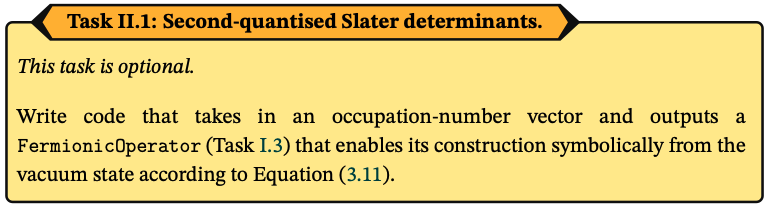

In [15]:
Image('2_1.png')

In [16]:
def occupation_to_operator(k):
    ops = [(i, 1) for i, occ in enumerate(k) if occ] #(i,1) for every occ=1
    return FermionicOperator.string(ops, 1.0)

In [17]:
k1 = (1,0,1,0)
op = occupation_to_operator(k1)
print('k1 =',op.to_openfermion())            


k2 = (0,1,1,0,1)
op2 = occupation_to_operator(k2)
print('k2 =',op2.to_openfermion())          

k1 = (1+0j) [0^ 2^]
k2 = (1+0j) [1^ 2^ 4^]


In the form $|\mathbf{k}\rangle=\left[\prod_{p=0}^{n} \left(\hat{a}_p^\dagger\right)^{k_p}\right]|\text{vac}\rangle=\left(\hat{a}_0^\dagger\right)^{k_0}\left(\hat{a}_1^\dagger\right)^{k_1}\cdots\left(\hat{a}_n^\dagger\right)^{k_n}|00\cdots0\rangle=\begin{cases}\left(\hat{a}_0^\dagger\right)^{k_0}\left(\hat{a}_1^\dagger\right)^{k_1}\cdots\left(\hat{a}_{n-1}^\dagger\right)^{k_{n-1}}|00\cdots01\rangle,& k_n=1\\\left(\hat{a}_0^\dagger\right)^{k_0}\left(\hat{a}_1^\dagger\right)^{k_1}\cdots\left(\hat{a}_{n-1}^\dagger\right)^{k_{n-1}}|00\cdots00\rangle,& k_n=0\end{cases}$ fermionic anticommutation is respected by construction because the creation operators are applied in descending order.

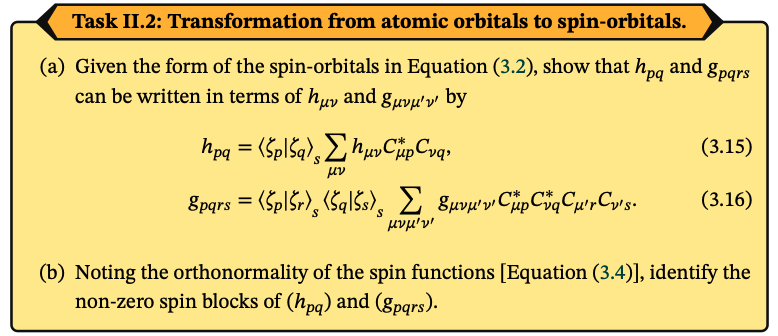

In [18]:
Image('2_2.png')

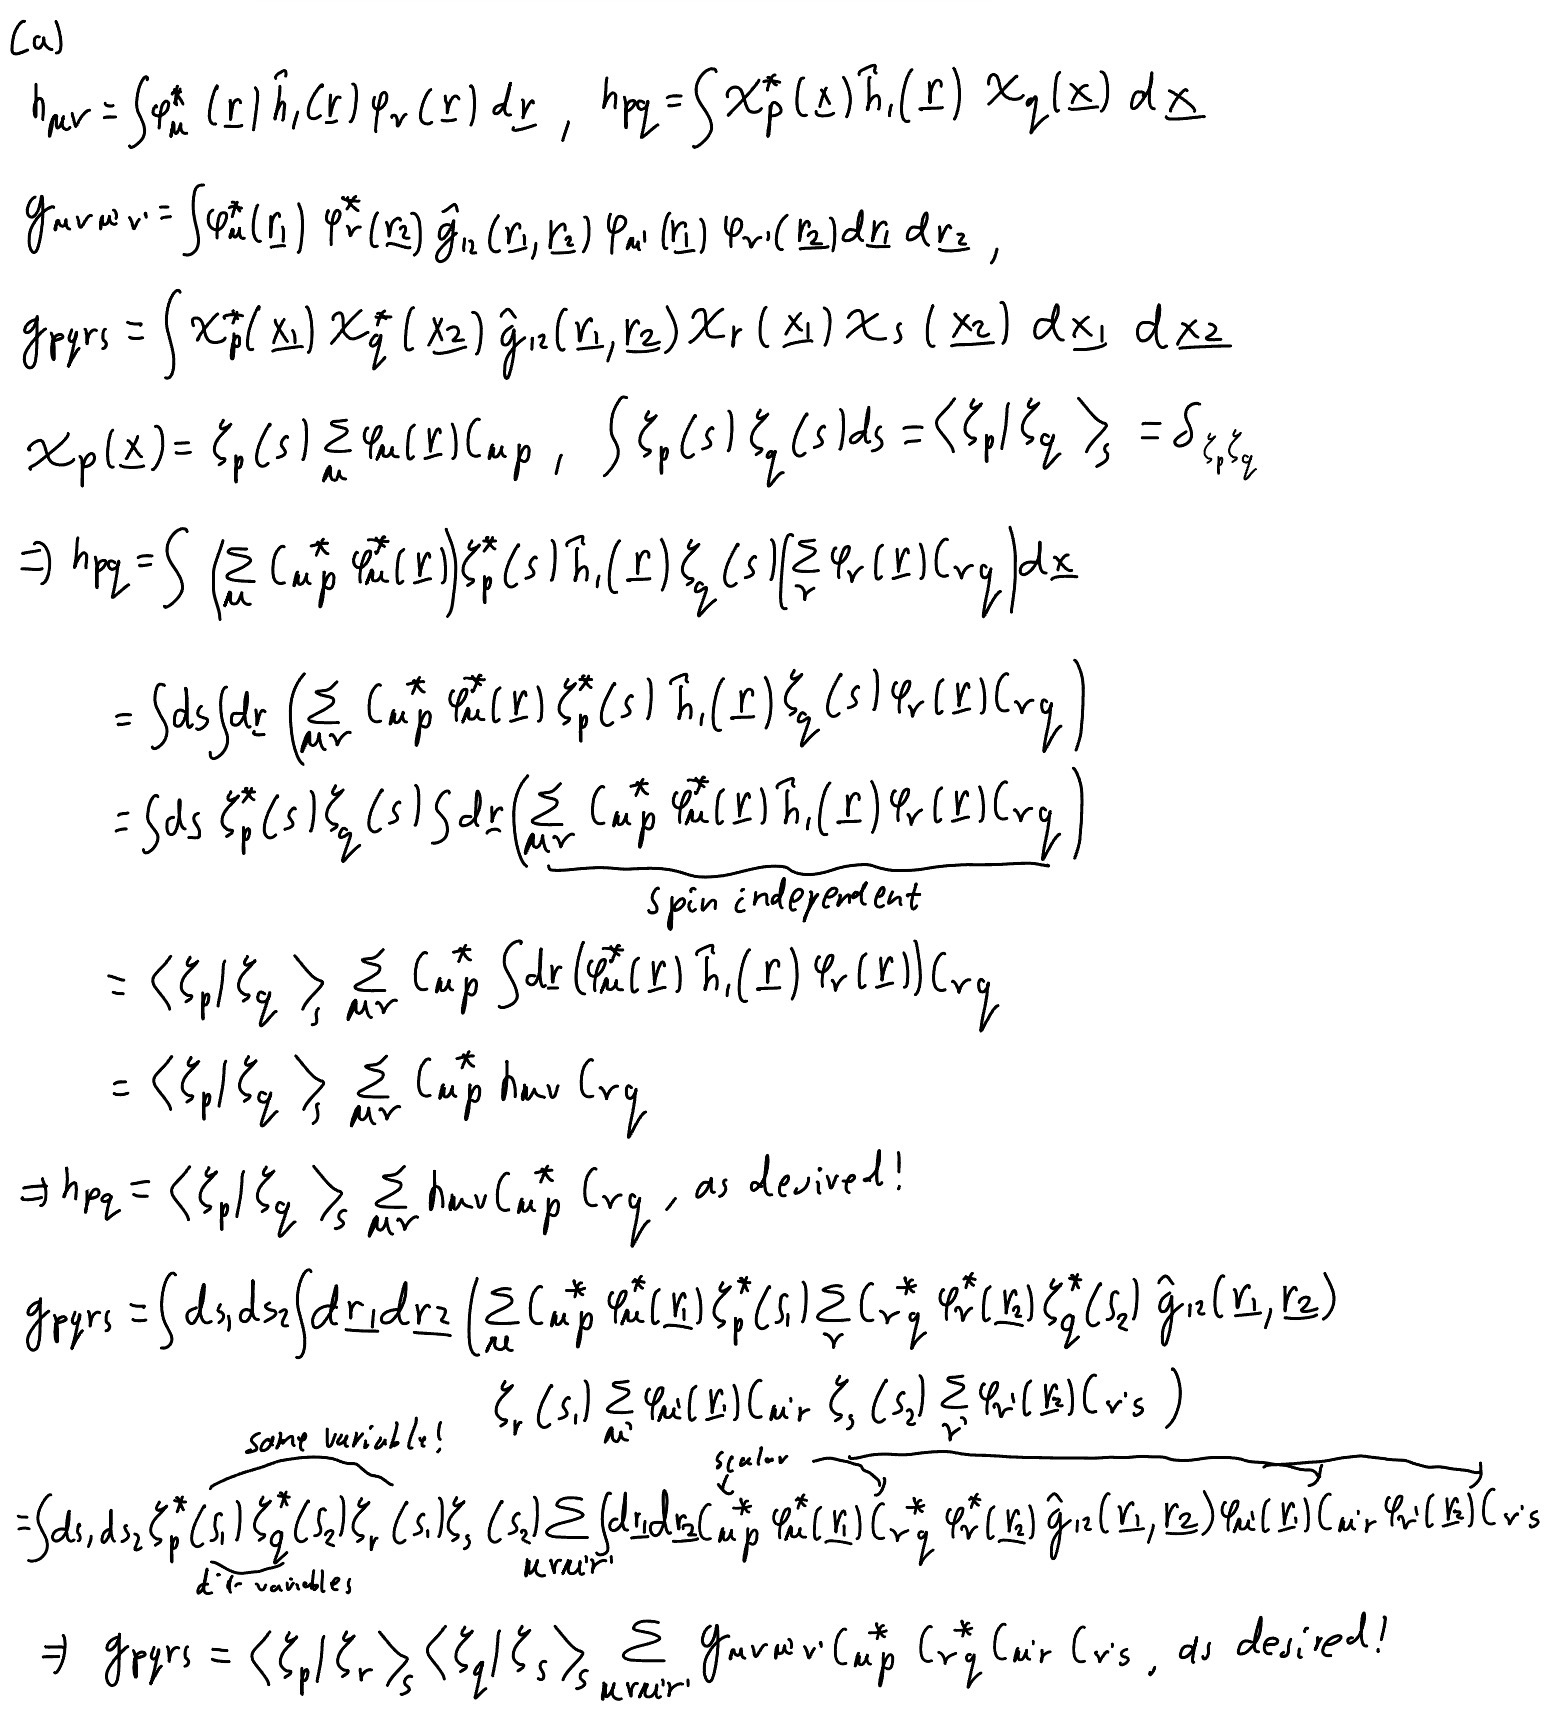

In [19]:
Image('2_2a.jpg')

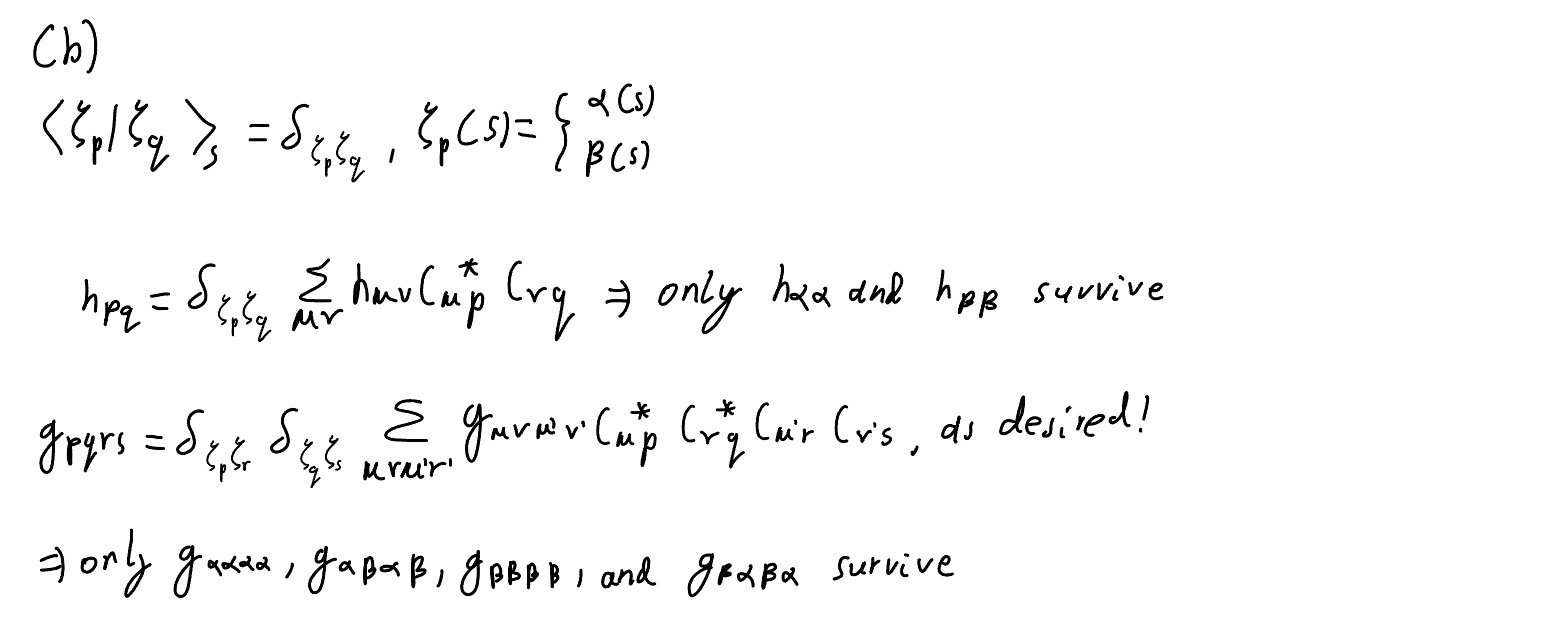

In [20]:
Image('2_2b.jpg')

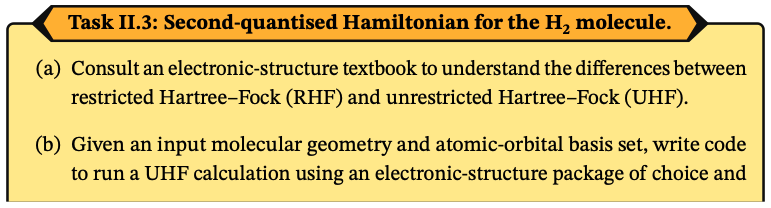

In [21]:
Image('2_3a.png')

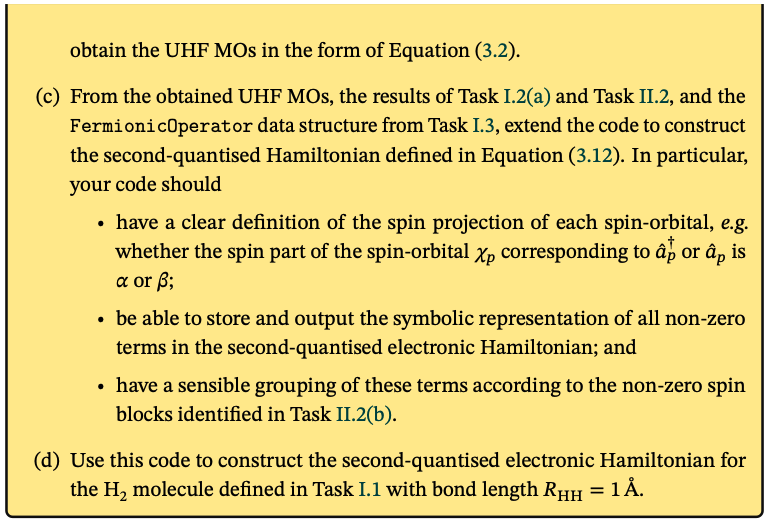

In [22]:
Image('2_3b.png')

**(a)**

Restricted Hartree-Fock (RHF) uses the same spatial orbital for the $\alpha$ and $\beta$ electrons in each pair. It works best for closed-shell molecules, however since the same spatial orbital is used, it cannot describe bond breaking into open-shell molecules/atoms. E.g. H$_2$ dissociates into H$^+$ and H$^-$, rather than two H atoms.

Unrestricted Hartree-Fock (UHF) uses separate spatial orbitals for $\alpha$ and $\beta$ electrons. UHF can be used for open and closed shell molecules, and usually dissociates correctly. At equilibrium geometry for closed shell molecules, RHF and UHF wavefunctions are almost identical. RHF wavefunctions are usually used for closed shells, because it is cheaper, however it shouldn't be used for closed shells that may dissociate into open shells. Separate spatial orbitals introduce 'spin contamination' error, whose size depends on the chemical system involved [1].

**(b)**

In [23]:
def uhf_mos(atom, basis, unit="Angstrom", charge=0, spin=0):

    mol = gto.Mole()
    mol.atom = atom
    mol.unit = unit
    mol.basis = basis
    mol.charge = charge
    mol.spin = spin
    mol.build()

    mf = scf.UHF(mol).run()

    C_alpha, C_beta = mf.mo_coeff
    ao_labels = mol.ao_labels()

    return C_alpha, C_beta, ao_labels

**(c)**

Note 1

Noting that $\sum_{\mu\nu}h_{\mu\nu}C_{\mu p}^*C_{\nu q}=\sum_{\mu}C_{\mu p}^*\sum_{\nu}h_{\mu\nu}C_{\nu q}=\sum_{\mu}\left(C^\dagger\right)_{p\mu}\left(hC\right)_{\mu q}=\left(C^\dagger hC\right)_{pq}$

Note 2

In [24]:
a = np.arange(16).reshape(2,2,2,2)
b = np.arange(4).reshape(2,2)
print(a)
print(b)

[[[[ 0  1]
   [ 2  3]]

  [[ 4  5]
   [ 6  7]]]


 [[[ 8  9]
   [10 11]]

  [[12 13]
   [14 15]]]]
[[0 1]
 [2 3]]


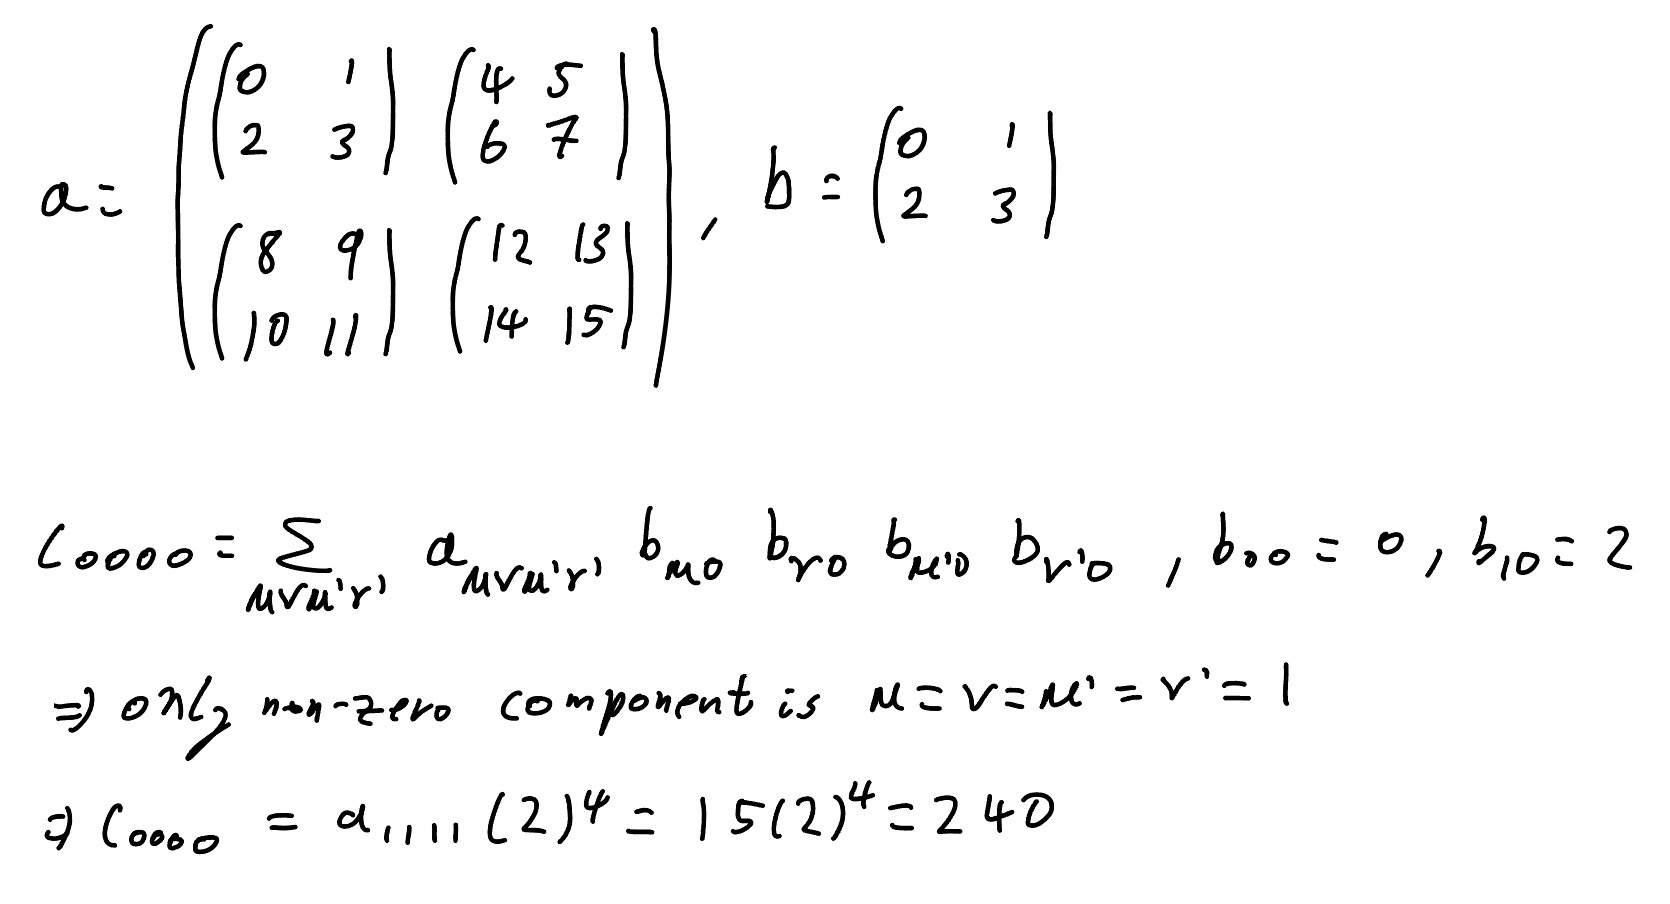

In [25]:
Image('note_2.jpg')

In [26]:
c=np.einsum('abcd,ap,bq,cr,ds->pqrs', a, b, b, b, b)
print(c)

[[[[ 240  472]
   [ 464  912]]

  [[ 448  880]
   [ 864 1696]]]


 [[[ 416  816]
   [ 800 1568]]

  [[ 768 1504]
   [1472 2880]]]]


In [27]:
def second_quantized_hamiltonian(atom, basis, unit = "Angstrom", charge = 0, spin = 0):    
    
    C_alpha, C_beta, ao_labels=uhf_mos(atom,basis,unit,charge, spin)
    h,g,v=core_and_eri(atom,basis,unit,charge,spin)

    # Note 1 above 
    h_aa = C_alpha.conj().T @ h @ C_alpha
    h_bb = C_beta.conj().T  @ h @ C_beta

    # Note 2 above
    g_aaaa = np.einsum('abcd,ap,bq,cr,ds->pqrs', g, C_alpha.conj(), C_alpha.conj(), C_alpha, C_alpha)
    g_bbbb = np.einsum('abcd,ap,bq,cr,ds->pqrs', g, C_beta.conj(),  C_beta.conj(),  C_beta,  C_beta)
    g_abab = np.einsum('abcd,ap,bq,cr,ds->pqrs', g, C_alpha.conj(), C_beta.conj(),  C_alpha, C_beta)
    g_baba = np.einsum('abcd,ap,bq,cr,ds->pqrs', g, C_beta.conj(),  C_alpha.conj(), C_beta,  C_alpha)
    
    h_αα=FermionicOperator()
    h_ββ=FermionicOperator()
    g_αααα=FermionicOperator()
    g_αβαβ=FermionicOperator()
    g_βαβα=FermionicOperator()
    g_ββββ=FermionicOperator()
    
    nmo = h_aa.shape[0]  # number of spatial molecular orbitals (same for both?)

    for p in range(nmo):
        for q in range(nmo):
            #one-electron terms
            h_αα += FermionicOperator.string([(2*p, 1), (2*q, 0)], h_aa[p, q])
            # need different indexing since a_α neq a_β, have α even, β odd
            h_ββ += FermionicOperator.string([(2*p+1, 1), (2*q+1, 0)], h_bb[p, q])
            for r in range(nmo):
                for s in range(nmo):
                    #two-electron terms
                    #swap q and r as using chemist notation
                    g_αααα+=FermionicOperator.string([(2*p, 1), (2*q, 1), (2*s, 0), (2*r, 0)],g_aaaa[p,r,q,s])
                    g_αβαβ+=FermionicOperator.string([(2*p, 1), (2*q+1, 1), (2*s+1, 0), (2*r, 0)],g_abab[p,r,q,s])
                    g_βαβα+=FermionicOperator.string([(2*p+1, 1), (2*q, 1), (2*s, 0), (2*r+1, 0)],g_baba[p,r,q,s])
                    g_ββββ+=FermionicOperator.string([(2*p+1, 1), (2*q+1, 1), (2*s+1, 0), (2*r+1, 0)],g_bbbb[p,r,q,s])       
                        
    H = h_αα + h_ββ + 0.5*(g_αααα + g_αβαβ + g_βαβα + g_ββββ) + FermionicOperator.string([], v)#need constant of same form
    return H

**(d)**

In [28]:
atom = """
H 0.000000 0.000000 0.000000
H 0.000000 0.000000 1.000000
"""
basis = "sto-3g"

H = second_quantized_hamiltonian(atom=atom, basis="sto-3g")
print(H)

converged SCF energy = -1.06610864931794  <S^2> = 2.220446e-16  2S+1 = 1
(0.52917721092+0j) [] +
(-1.110844179883727+0j) [0^ 0] +
(0.3132012497647588+0j) [0^ 0^ 0 0] +
(0.09839529174273509+0j) [0^ 0^ 2 2] +
(0.3132012497647588+0j) [0^ 1^ 1 0] +
(0.09839529174273509+0j) [0^ 1^ 3 2] +
(0.09839529174273508+0j) [0^ 2^ 0 2] +
(0.3108533815598566+0j) [0^ 2^ 2 0] +
(0.09839529174273508+0j) [0^ 3^ 1 2] +
(0.3108533815598566+0j) [0^ 3^ 3 0] +
(0.3132012497647588+0j) [1^ 0^ 0 1] +
(0.09839529174273509+0j) [1^ 0^ 2 3] +
(-1.110844179883727+0j) [1^ 1] +
(0.3132012497647588+0j) [1^ 1^ 1 1] +
(0.09839529174273509+0j) [1^ 1^ 3 3] +
(0.09839529174273508+0j) [1^ 2^ 0 3] +
(0.3108533815598566+0j) [1^ 2^ 2 1] +
(0.09839529174273508+0j) [1^ 3^ 1 3] +
(0.3108533815598566+0j) [1^ 3^ 3 1] +
(0.31085338155985676+0j) [2^ 0^ 0 2] +
(0.09839529174273512+0j) [2^ 0^ 2 0] +
(0.31085338155985676+0j) [2^ 1^ 1 2] +
(0.09839529174273512+0j) [2^ 1^ 3 0] +
(-0.5891210037060842+0j) [2^ 2] +
(0.0983952917427351+0j) [2^ 2^ 

Compare against PySCF [3].

In [29]:
mol = MolecularData(atom, basis, multiplicity=1)
mol = run_pyscf(mol)

H_ref = get_fermion_operator(mol.get_molecular_hamiltonian()) 
print(H_ref)

0.52917721092 [] +
-1.110844179883727 [0^ 0] +
0.3132012497647589 [0^ 0^ 0 0] +
0.09839529174273509 [0^ 0^ 2 2] +
0.3132012497647589 [0^ 1^ 1 0] +
0.09839529174273509 [0^ 1^ 3 2] +
0.09839529174273509 [0^ 2^ 0 2] +
0.3108533815598565 [0^ 2^ 2 0] +
0.09839529174273509 [0^ 3^ 1 2] +
0.3108533815598565 [0^ 3^ 3 0] +
0.3132012497647589 [1^ 0^ 0 1] +
0.09839529174273509 [1^ 0^ 2 3] +
-1.110844179883727 [1^ 1] +
0.3132012497647589 [1^ 1^ 1 1] +
0.09839529174273509 [1^ 1^ 3 3] +
0.09839529174273509 [1^ 2^ 0 3] +
0.3108533815598565 [1^ 2^ 2 1] +
0.09839529174273509 [1^ 3^ 1 3] +
0.3108533815598565 [1^ 3^ 3 1] +
0.31085338155985676 [2^ 0^ 0 2] +
0.09839529174273509 [2^ 0^ 2 0] +
0.31085338155985676 [2^ 1^ 1 2] +
0.09839529174273509 [2^ 1^ 3 0] +
-0.5891210037060843 [2^ 2] +
0.09839529174273509 [2^ 2^ 0 0] +
0.3265353734712868 [2^ 2^ 2 2] +
0.09839529174273509 [2^ 3^ 1 0] +
0.3265353734712868 [2^ 3^ 3 2] +
0.31085338155985676 [3^ 0^ 0 3] +
0.09839529174273509 [3^ 0^ 2 1] +
0.31085338155985676 [3

Good agreement.

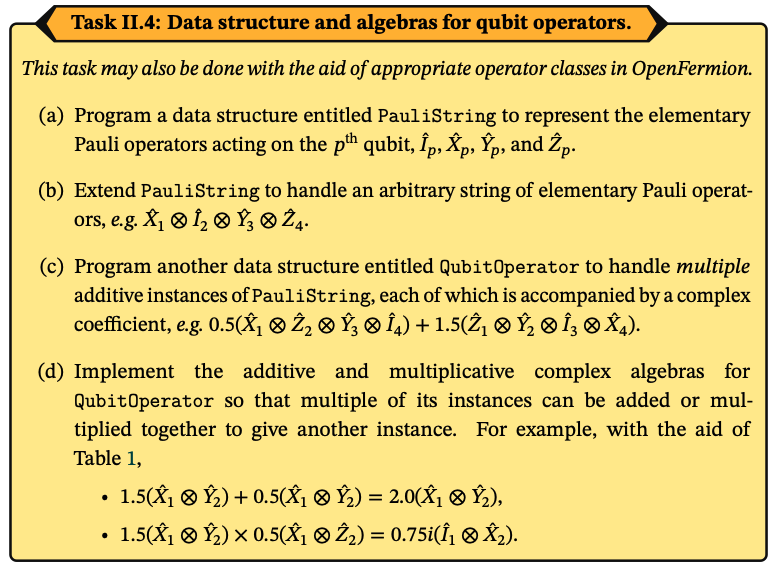

In [30]:
Image('2_4.png')

First verify multiplication rules, leaving out identity since it is trivial.

In [31]:
X = np.array([[0, 1], [1, 0]], dtype=complex)
Y = np.array([[0, -1j], [1j, 0]], dtype=complex)
Z = np.array([[1, 0], [0, -1]], dtype=complex)

print("XX =",X@X)
print("\nXY =",X@Y)
print("\nXZ =",X@Z)
print("\nYX =",Y@X)
print("\nYY =",Y@Y)
print("\nYZ =",Y@Z)
print("\nZX =",Z@X)
print("\nZY =",Z@Y)
print("\nZZ =",Z@Z)

XX = [[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]

XY = [[0.+1.j 0.+0.j]
 [0.+0.j 0.-1.j]]

XZ = [[ 0.+0.j -1.+0.j]
 [ 1.+0.j  0.+0.j]]

YX = [[0.-1.j 0.+0.j]
 [0.+0.j 0.+1.j]]

YY = [[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]

YZ = [[0.+0.j 0.+1.j]
 [0.+1.j 0.+0.j]]

ZX = [[ 0.+0.j  1.+0.j]
 [-1.+0.j  0.+0.j]]

ZY = [[0.+0.j 0.-1.j]
 [0.-1.j 0.+0.j]]

ZZ = [[1.+0.j 0.+0.j]
 [0.+0.j 1.+0.j]]


As desired!

**(a)**

In [32]:
class PauliString:
    def __init__(self, ops=()):  #ops like [(1,"X"), (2,"I"),...]
        self._qop = ofQubitOperator(())  #identity
#(b)
        for p, op in ops:
            if op != "I":
                self._qop *= ofQubitOperator(((p, op),), 1.0)

    def __str__(self): 
        return str(self._qop)
        
    def to_openfermion(self): 
        return self._qop

In [33]:
print(PauliString([(1,"X"),(2,"I"),(3,"Y")]))

1.0 [X1 Y3]


**(c)**

In [34]:
class QubitOperator:
    def __init__(self, terms=()):
        self._qop = ofQubitOperator()#zero operator
        for coeff, ps in terms:
            self._qop += complex(coeff) * ps.to_openfermion()

    def to_openfermion(self):
        return self._qop

    def __str__(self):
        return str(self._qop)
#(d)
    def __add__(self, other):
        out = QubitOperator()
        out._qop = self._qop + other._qop
        return out

    def __mul__(self, other):
        out = QubitOperator()
        out._qop = self._qop * other._qop
        return out

    def __rmul__(self, other):
        out = QubitOperator()
        out._qop = complex(other) * self._qop    
        return out

In [35]:
psA = PauliString([(1,"X"), (2,"Y")])
psB = PauliString([(1,"X"), (2,"Z")])
a=QubitOperator([(1.5,psA),(0.5,psA)])
b=QubitOperator([(1.5,psA)])
c=QubitOperator([(0.5,psB)])
print(a)
print(b*c)

(2+0j) [X1 Y2]
0.75j [X2]


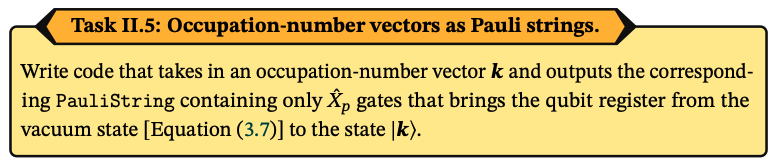

In [36]:
Image('2_5.png')

In [37]:
def occupation_to_paulistring(k):
    ops = [(p, "X") for p, occ in enumerate(k) if occ]
    return PauliString(ops)

ps = occupation_to_paulistring(k1)
print(ps)

1.0 [X0 X2]


Verifying that $\hat{a}^\dagger_p \leftrightarrow \hat{q}^\dagger_p$ and $\hat{a}_p \leftrightarrow \hat{q}_p$.

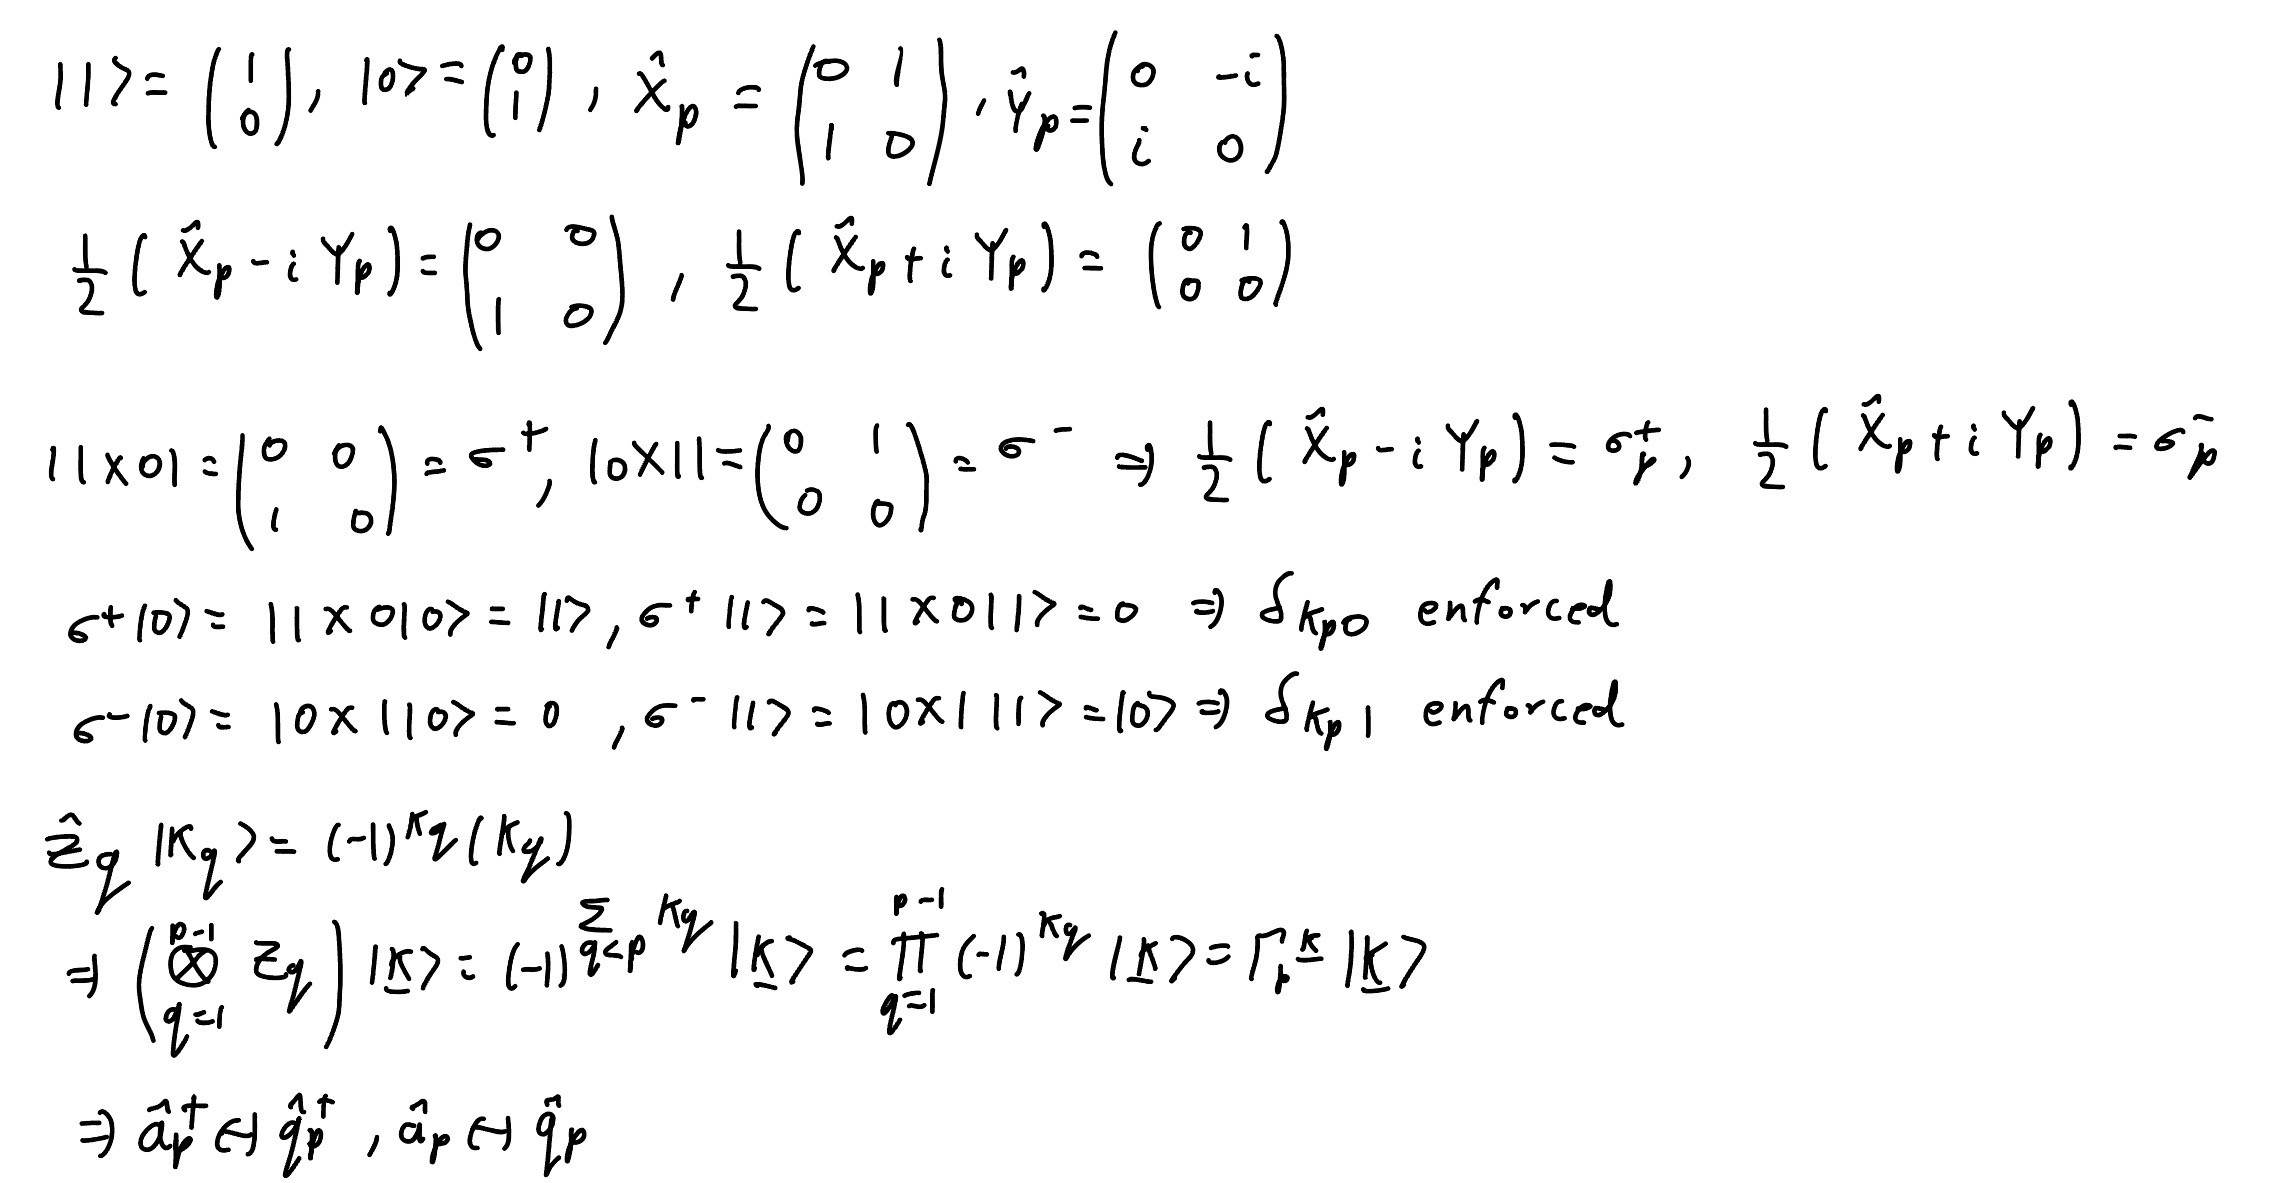

In [38]:
Image('JW.jpg')

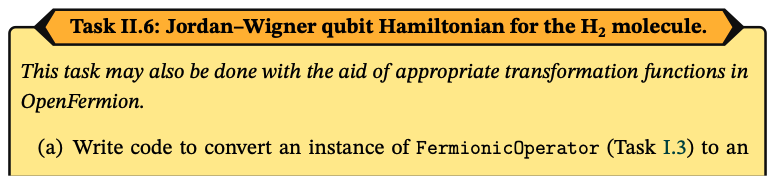

In [39]:
Image('2_6a.png')

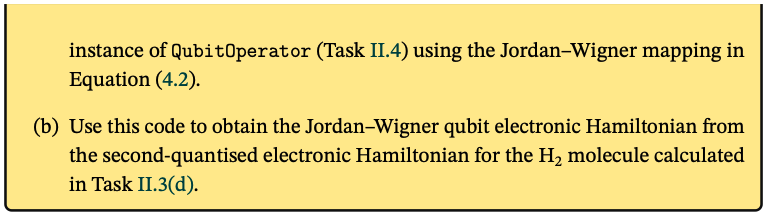

In [40]:
Image('2_6b.png')

**(a)**

In [41]:
a=FermionicOperator.string([(1,1), (2,1), (3,0), (4,0)], 0.5).to_openfermion()
a.terms.items()

dict_items([(((1, 1), (2, 1), (3, 0), (4, 0)), (0.5+0j))])

In [42]:
def jw_transform(ferm_op):
    of_ferm = ferm_op.to_openfermion()
    qop = ofQubitOperator() 

    for term, coeff in of_ferm.terms.items():
        jw = ofQubitOperator((), 1.0) 

        for p, ca in term:
            # Z string
            for q in range(p):
                jw *= ofQubitOperator(((q,"Z"),), 1.0)
            if ca == 1:   
                #creation
                jw *= (0.5 * ofQubitOperator(((p,"X"),), 1.0) - 0.5j * ofQubitOperator(((p,"Y"),), 1.0))
            else:             
                # annihilation
                jw *= (0.5 * ofQubitOperator(((p,"X"),), 1.0) + 0.5j * ofQubitOperator(((p,"Y"),), 1.0))

        qop += complex(coeff) * jw

    mapped = QubitOperator()
    mapped._qop = qop
    #map to QubitOperator class
    return mapped

**(b)**

In [43]:
H_q = jw_transform(H)
print(H_q)

(-0.32760818967481076+0j) [] +
(-0.049197645871367546+0j) [X0 X1 Y2 Y3] +
(0.049197645871367546+0j) [X0 Y1 Y2 X3] +
(0.049197645871367546+0j) [Y0 X1 X2 Y3] +
(-0.049197645871367546+0j) [Y0 Y1 X2 X3] +
(0.13716572937099492+0j) [Z0] +
(0.1566006248823794+0j) [Z0 Z1] +
(0.10622904490856078+0j) [Z0 Z2] +
(0.15542669077992832+0j) [Z0 Z3] +
(0.13716572937099483+0j) [Z1] +
(0.15542669077992832+0j) [Z1 Z2] +
(0.10622904490856078+0j) [Z1 Z3] +
(-0.13036292057109045+0j) [Z2] +
(0.1632676867356434+0j) [Z2 Z3] +
(-0.13036292057109042+0j) [Z3]


Compare against PySCF.

In [44]:
atom = """
H 0.000000 0.000000 0.000000
H 0.000000 0.000000 1.000000
"""
basis = "sto-3g"
mol = MolecularData(atom, basis, multiplicity=1)
mol = run_pyscf(mol)

H_ref = jordan_wigner(mol.get_molecular_hamiltonian()) 
print(H_ref)

-0.3276081896748101 [] +
-0.049197645871367546 [X0 X1 Y2 Y3] +
0.049197645871367546 [X0 Y1 Y2 X3] +
0.049197645871367546 [Y0 X1 X2 Y3] +
-0.049197645871367546 [Y0 Y1 X2 X3] +
0.13716572937099492 [Z0] +
0.15660062488237944 [Z0 Z1] +
0.10622904490856078 [Z0 Z2] +
0.15542669077992832 [Z0 Z3] +
0.13716572937099492 [Z1] +
0.15542669077992832 [Z1 Z2] +
0.10622904490856078 [Z1 Z3] +
-0.13036292057109033 [Z2] +
0.1632676867356434 [Z2 Z3] +
-0.13036292057109033 [Z3]


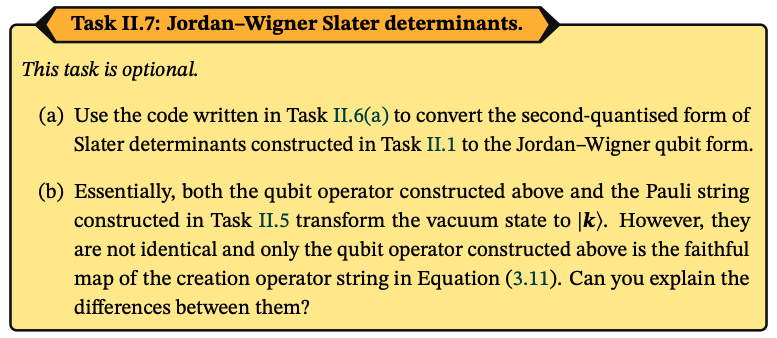

In [45]:
Image('2_7.png')

**(a)**

In [46]:
op = occupation_to_operator(k1)
print('For second-quantized k1 =',op.to_openfermion(),'the Jordan-Wigner qubit form is:',jw_transform(op))  

For second-quantized k1 = (1+0j) [0^ 2^] the Jordan-Wigner qubit form is: (0.25+0j) [X0 Z1 X2] +
-0.25j [X0 Z1 Y2] +
-0.25j [Y0 Z1 X2] +
(-0.25+0j) [Y0 Z1 Y2]


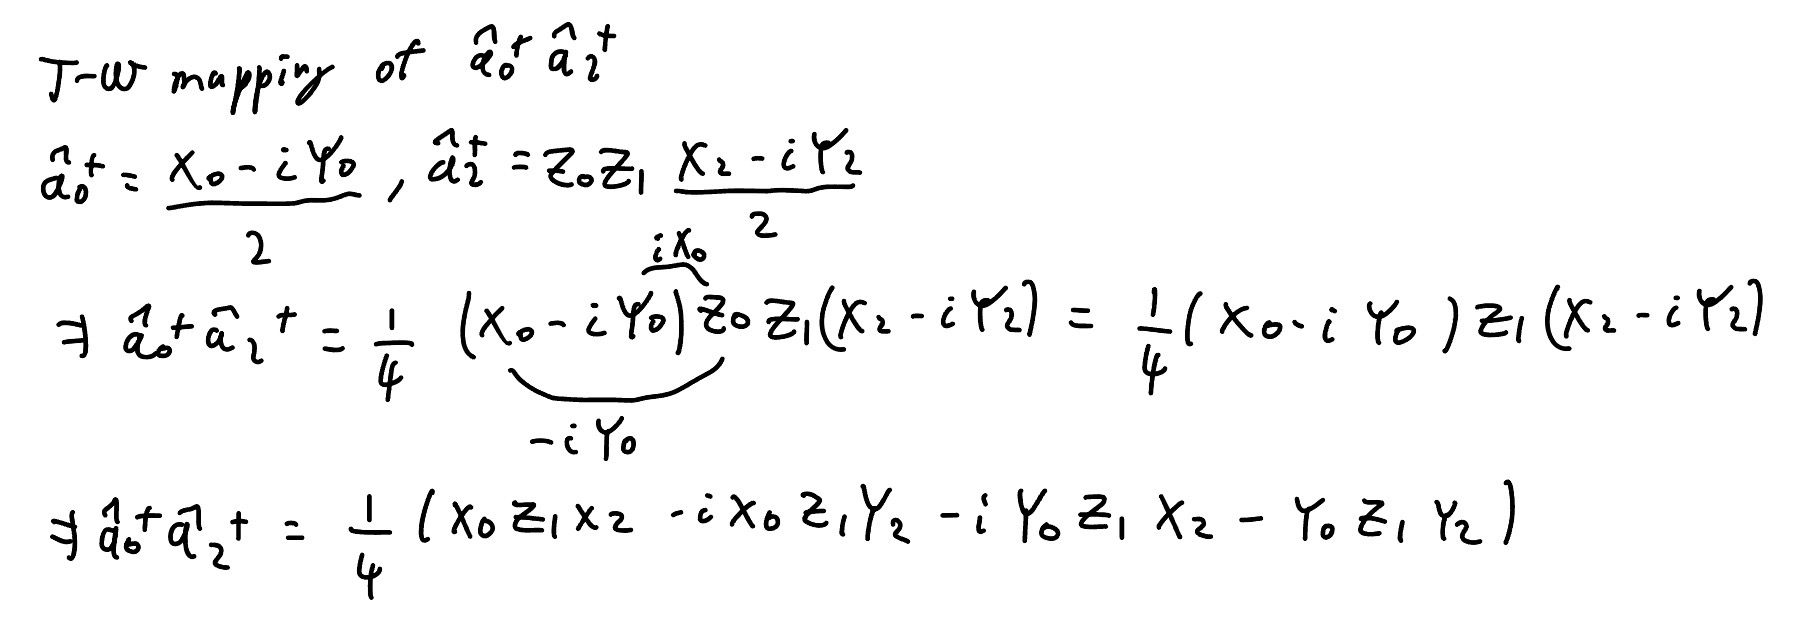

In [47]:
Image('JWexample.jpg')

**(b)**

Jordan-Wigner mapping is the true operator map of $\prod_p (a_p^\dagger)^{k_p}$, including the parity string $\bigotimes_{q=0}^{p-1} \hat{Z}_q$ and the $(\hat{X}_p \mp i\hat{Y}_p)/2$ structure, so it expands into a sum of Pauli strings that preserves fermionic anticommutation.

The Pauli string $\hat{X}_0\hat{X}_2$ is only a state preparation shortcut that flips $|000\rangle \to |101\rangle$. It does not enforce fermionic occupancy rules or anticommutation. For example $\hat{X}_0\hat{X}_2|011\rangle = |110\rangle$, while $\hat a_0^\dagger \hat a_2^\dagger|011\rangle = 0$ because creating on an already occupied mode gives zero.

# Part III
## Simulation Framework

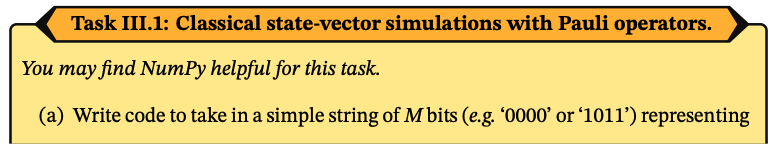

In [48]:
Image('3_1a.png')

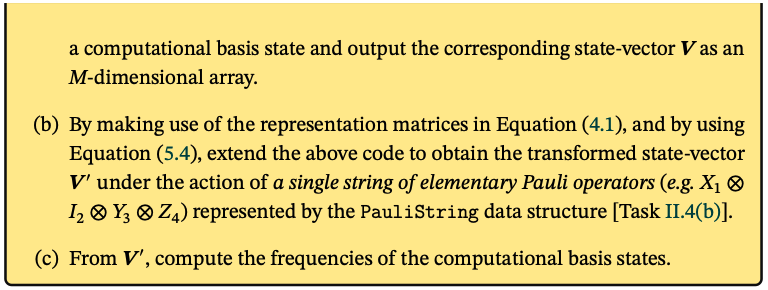

In [49]:
Image('3_1b.png')

**(a)**

In [50]:
def b_svtensor(bstr):
    bits = tuple(int(b) for b in bstr.strip())
    M = len(bits)
    V = np.zeros((2,) * M, dtype=complex)
    V[bits] = 1 #sets amplitude of bstr to 1
    return V

In [51]:
V = b_svtensor("1011")
print(V.shape)
print(V[1,0,1,1]) 
print(V)

(2, 2, 2, 2)
(1+0j)
[[[[0.+0.j 0.+0.j]
   [0.+0.j 0.+0.j]]

  [[0.+0.j 0.+0.j]
   [0.+0.j 0.+0.j]]]


 [[[0.+0.j 0.+0.j]
   [0.+0.j 1.+0.j]]

  [[0.+0.j 0.+0.j]
   [0.+0.j 0.+0.j]]]]


**(b)**

Note 3

$V'_{\cdots i_{p-1}'ai_{p+1}' \cdots}=\sum_{b}V_{\cdots i_{p-1}bi_{p+1}\cdots}U_{ab}$

In [52]:
pauli = {"I": np.eye(2, dtype=complex),"X": np.array([[0, 1], [1, 0]], dtype=complex),
         "Y": np.array([[0, -1j], [1j, 0]], dtype=complex),"Z": np.array([[1, 0], [0, -1]], dtype=complex)}

def apply_paulistring(V, ps):
    #V from b_svtensor
    qop = ps.to_openfermion()
    terms = list(qop.terms.items())
        
    term, coeff = terms[0]   
    # term is e.g. ((p,'X'), (q,'Z'), ...)
    Vp = V * coeff
    for p, op in term:
        Vp = np.tensordot(pauli[op], Vp, axes=([1], [p])) #note 3
        Vp = np.moveaxis(Vp, 0, p) #tensordot inserts the new output index of the Pauli matrix as axis 0
    return Vp

**(c)**

In [53]:
def frequencies(Vp):
    probs = np.abs(Vp)**2
    return probs                

In [54]:
V = b_svtensor("1011")  
ps = PauliString([(0,"X"), (1,"I"), (2,"Y"), (3,"Z")])
#arbitrary

Vp = apply_paulistring(V, ps)
freq = frequencies(Vp)
print("V' =",Vp)
print("\nFrequency =",freq)
print("\nSum of frequencies =",freq.sum())

V' = [[[[0.+0.j 0.+1.j]
   [0.+0.j 0.+0.j]]

  [[0.+0.j 0.+0.j]
   [0.+0.j 0.+0.j]]]


 [[[0.+0.j 0.+0.j]
   [0.+0.j 0.+0.j]]

  [[0.+0.j 0.+0.j]
   [0.+0.j 0.+0.j]]]]

Frequency = [[[[0. 1.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]]]


 [[[0. 0.]
   [0. 0.]]

  [[0. 0.]
   [0. 0.]]]]

Sum of frequencies = 1.0


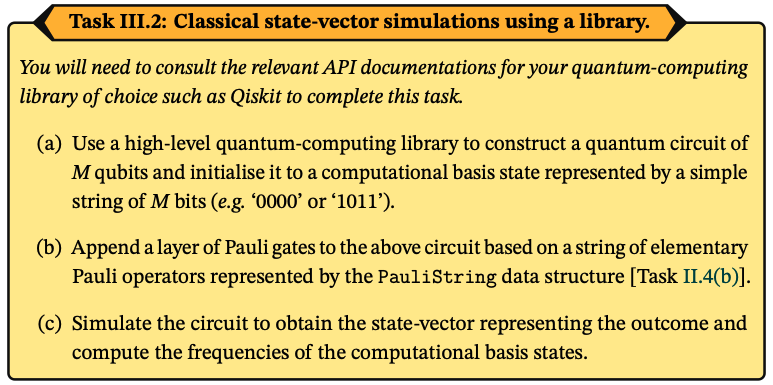

In [55]:
Image('3_2.png')

In [56]:
service = QiskitRuntimeService(name="oxford-chem")

management.get:WARNING:2026-02-02 17:13:10,178: Loading saved account: oxford-chem


**(a)**

'0000'


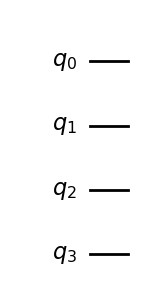

In [57]:
qc0000 = QuantumCircuit(4)


print("'0000'")
qc0000.draw("mpl")


'1011' (least significant bit last)


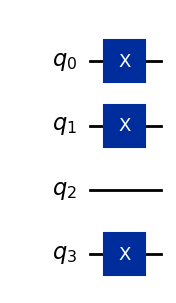

In [58]:
qc1011 = QuantumCircuit(4)
qc1011.x(0)
qc1011.x(1)
qc1011.x(3)
print("'1011' (least significant bit last)")
qc1011.draw("mpl")

**(b)**

In [59]:
def append_pauli(qc, ps):
    term = next(iter(ps.to_openfermion().terms)) #next gets first key from dict
    for p, op in term:
        if op == "X":
            qc.x(p)
        elif op == "Y":
            qc.y(p)
        elif op == "Z":
            qc.z(p)
    return qc

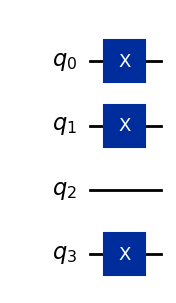

In [60]:
qc = QuantumCircuit(4)

ps = PauliString([(0, "X"), (1, "X"), (3, "X")])

append_pauli(qc, ps)
qc.draw("mpl")

**(c)**

**Check agreement with III.1 (a)**

In [61]:
sv = Statevector.from_instruction(qc)
print("Statevector :", sv.data)
probs = sv.probabilities_dict() 
print("Probabilities :", probs)

Statevector : [0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 1.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Probabilities : {np.str_('1011'): np.float64(1.0)}


Statevector agrees with III.1 (a)

In [62]:
# Use the least busy backend
backend = AerSimulator()
# A backend is the quantum computer or simulator that actually runs your circuit

print(backend.name)

aer_simulator


In [63]:
## Transpile
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_1=qc.copy()
qc_1.measure_all()
qc_isa = pm.run(qc_1)

In [64]:
sampler = Sampler(mode=backend) 
pubs = [qc_isa] # Primitive Unified Blocs, holds circuit
job = sampler.run(pubs, shots=1000) # repeats the circuit 1000 times
res = job.result()
 
counts = res[0].data.meas.get_counts()

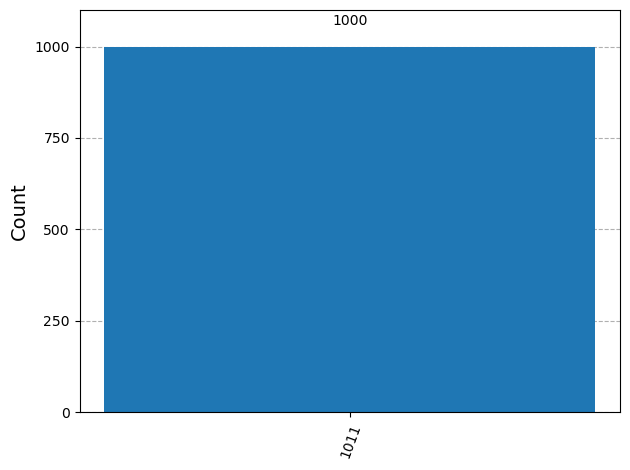

In [65]:
## Analysis

plot_histogram(counts)
#plt.hist(counts)

Aer simulator gives expected result for III.1 (a)

**Check agreement with III.1(c)**

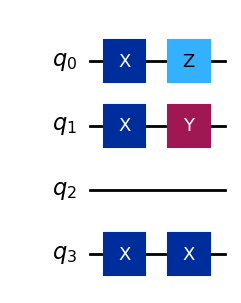

In [66]:
ps1 = PauliString([(3,"X"), (2,"I"), (1,"Y"), (0,"Z")]) #in little-endian
append_pauli(qc, ps1)
qc.draw("mpl")

In [67]:
sv = Statevector.from_instruction(qc)
print("Statevector :", sv.data)
probs = sv.probabilities_dict() 
print("Probabilities :", probs)

Statevector : [0.+0.j 0.+1.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j
 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j 0.+0.j]
Probabilities : {np.str_('0001'): np.float64(1.0)}


Statevector agrees with III.1 (c)

In [68]:
## Transpile
target = backend.target
pm = generate_preset_pass_manager(target=target, optimization_level=3)
qc_2=qc.copy()
qc_2.measure_all()
qc_isa = pm.run(qc_2)

In [69]:
sampler = Sampler(mode=backend) 
pubs = [qc_isa] # Primitive Unified Blocs, holds circuit
job = sampler.run(pubs, shots=1000) # repeats the circuit 1000 times
res = job.result()
 
counts = res[0].data.meas.get_counts()

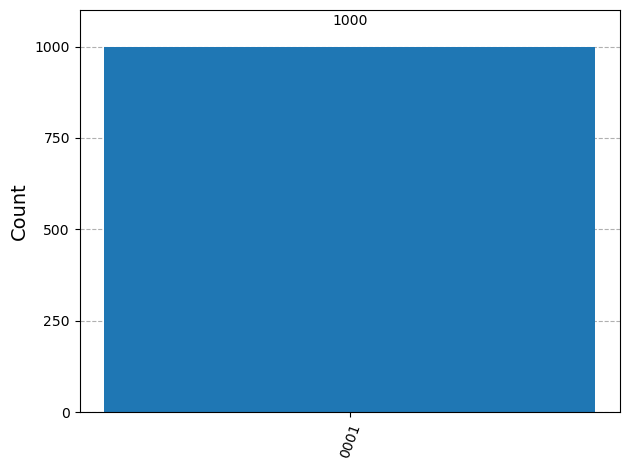

In [70]:
## Analysis

plot_histogram(counts)
#plt.hist(counts)

Aer simulator gives expected result for III.1 (c)

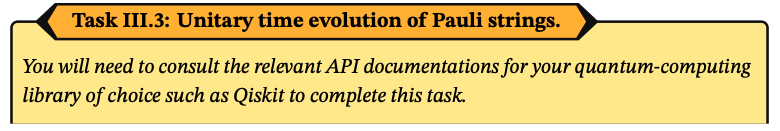

In [71]:
Image('3_3a.png')

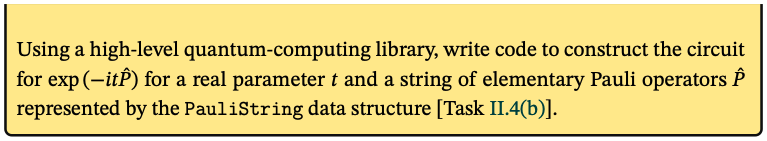

In [72]:
Image('3_3b.png')

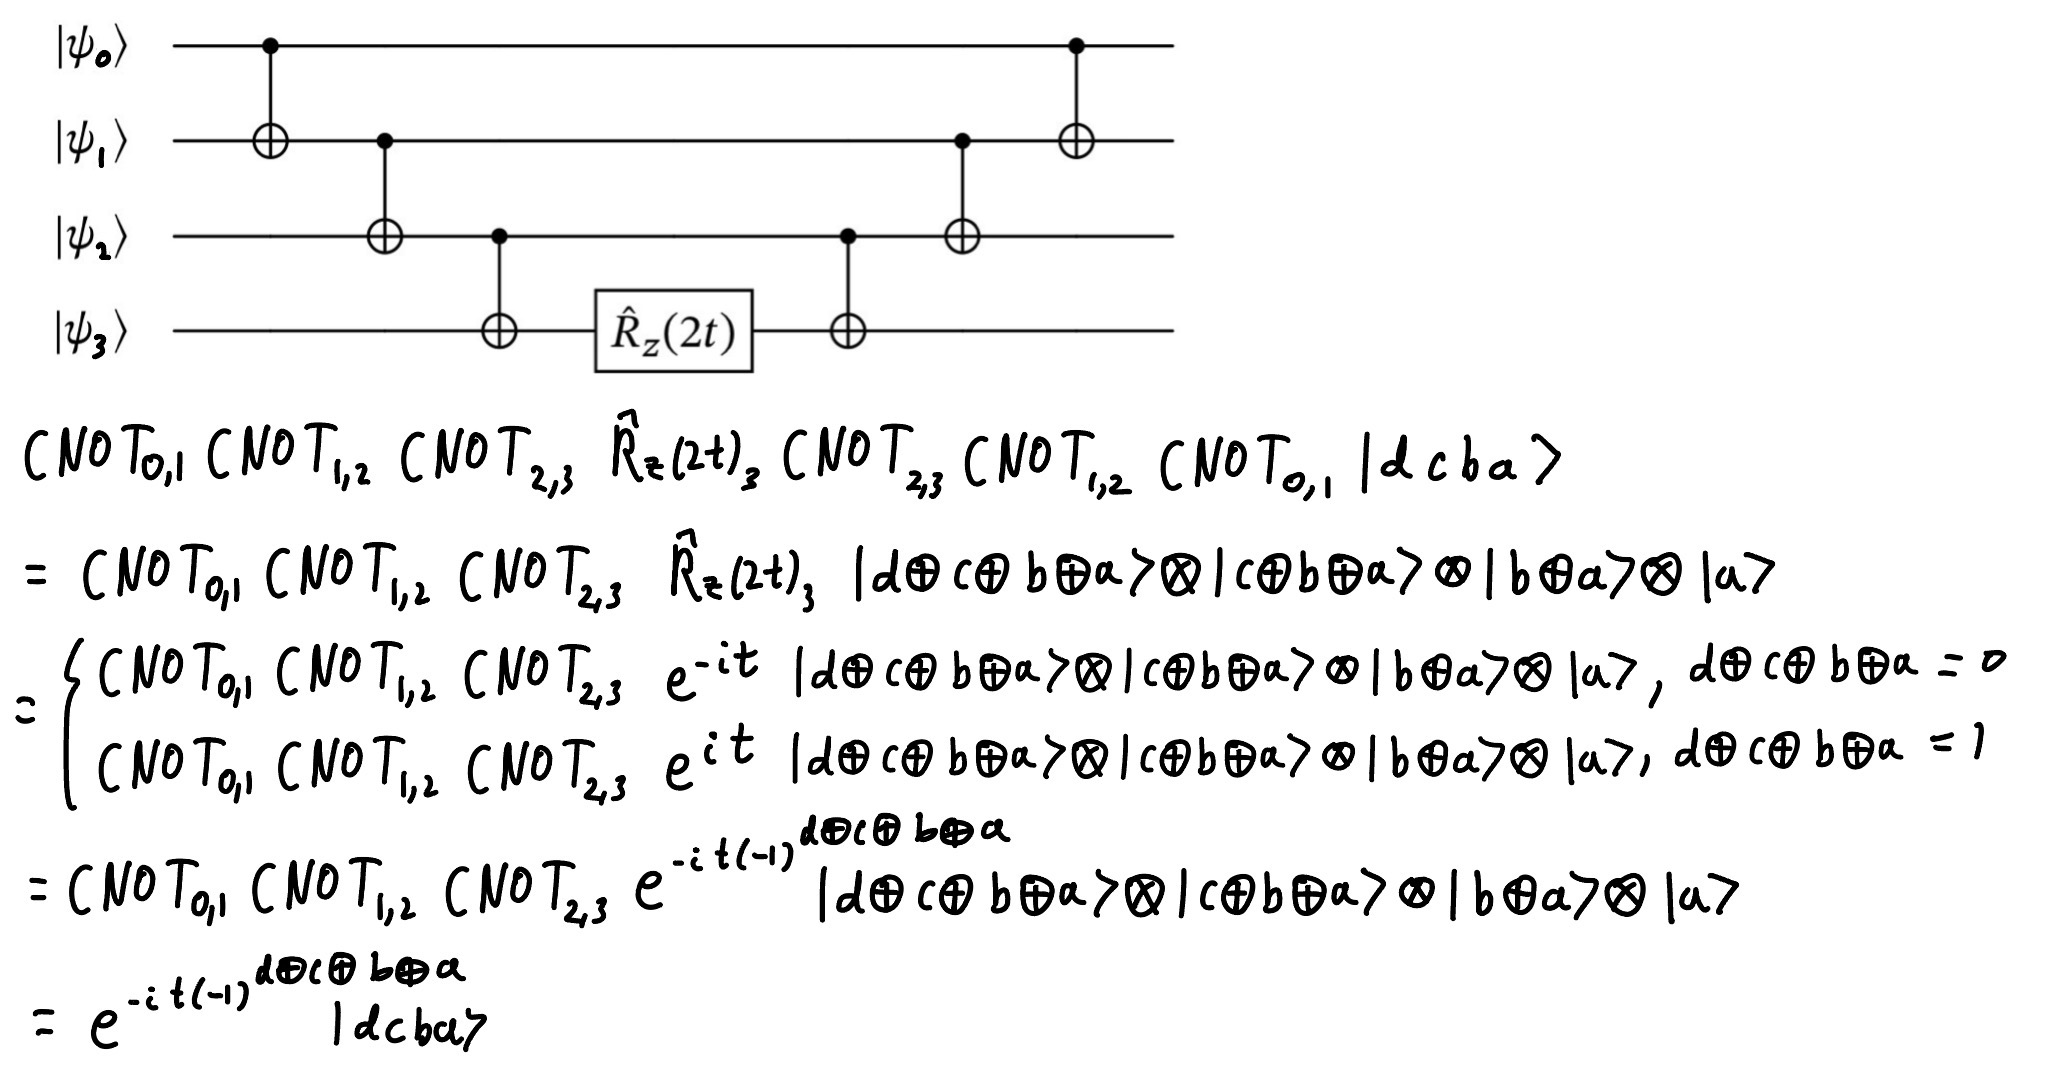

In [73]:
Image('3_3.jpg')

In [74]:
def exp_it(ps, t, num_qubits):
    qop = ps.to_openfermion()
    terms = list(qop.terms.items())

    term, coeff = terms[0]
    qc = QuantumCircuit(num_qubits)

    basis_changes = [] 
    #keep to uncompute
    for p, op in sorted(term, key=lambda x: x[0]):
        #sort by qubit index
        if op == "X":
            qc.h(p)
            basis_changes.append((p, "X"))
        elif op == "Y":
            qc.s(p)
            qc.h(p)
            basis_changes.append((p, "Y"))
        elif op == "Z":
            basis_changes.append((p, "Z"))
    for p in range(num_qubits-1):
        qc.cx(p, p+1)

    # Phase rotation
    qc.rz(2.0 * t, num_qubits -1)

    # uncompute 
    for p in reversed(range(num_qubits-1)):
        qc.cx(p, p+1)

    #undo basis changes
    for p, op in reversed(basis_changes):
        if op == "X":
            qc.h(p)
        elif op == "Y":
            qc.h(p)
            qc.sdg(p)
        elif op == "Z":
            pass

    return qc

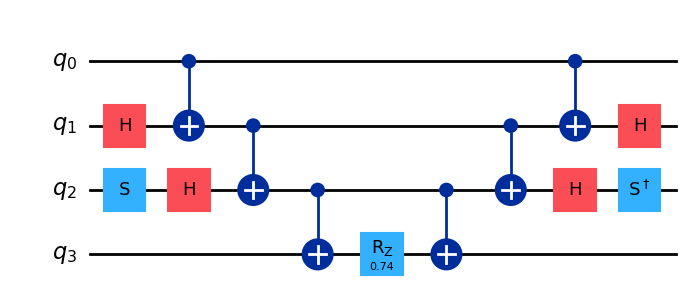

In [75]:
ps = PauliString([(0,"Z"),(1,"X"), (2,"Y"), (3,"Z")])
t = 0.37
qc = exp_it(ps, t, num_qubits=4)
qc.draw("mpl")

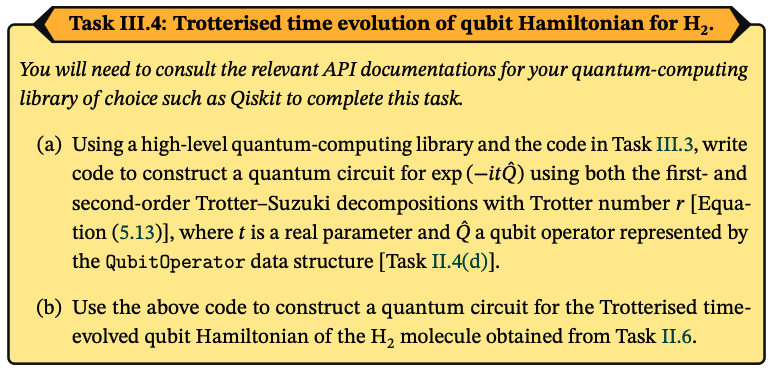

In [76]:
Image('3_4.png')

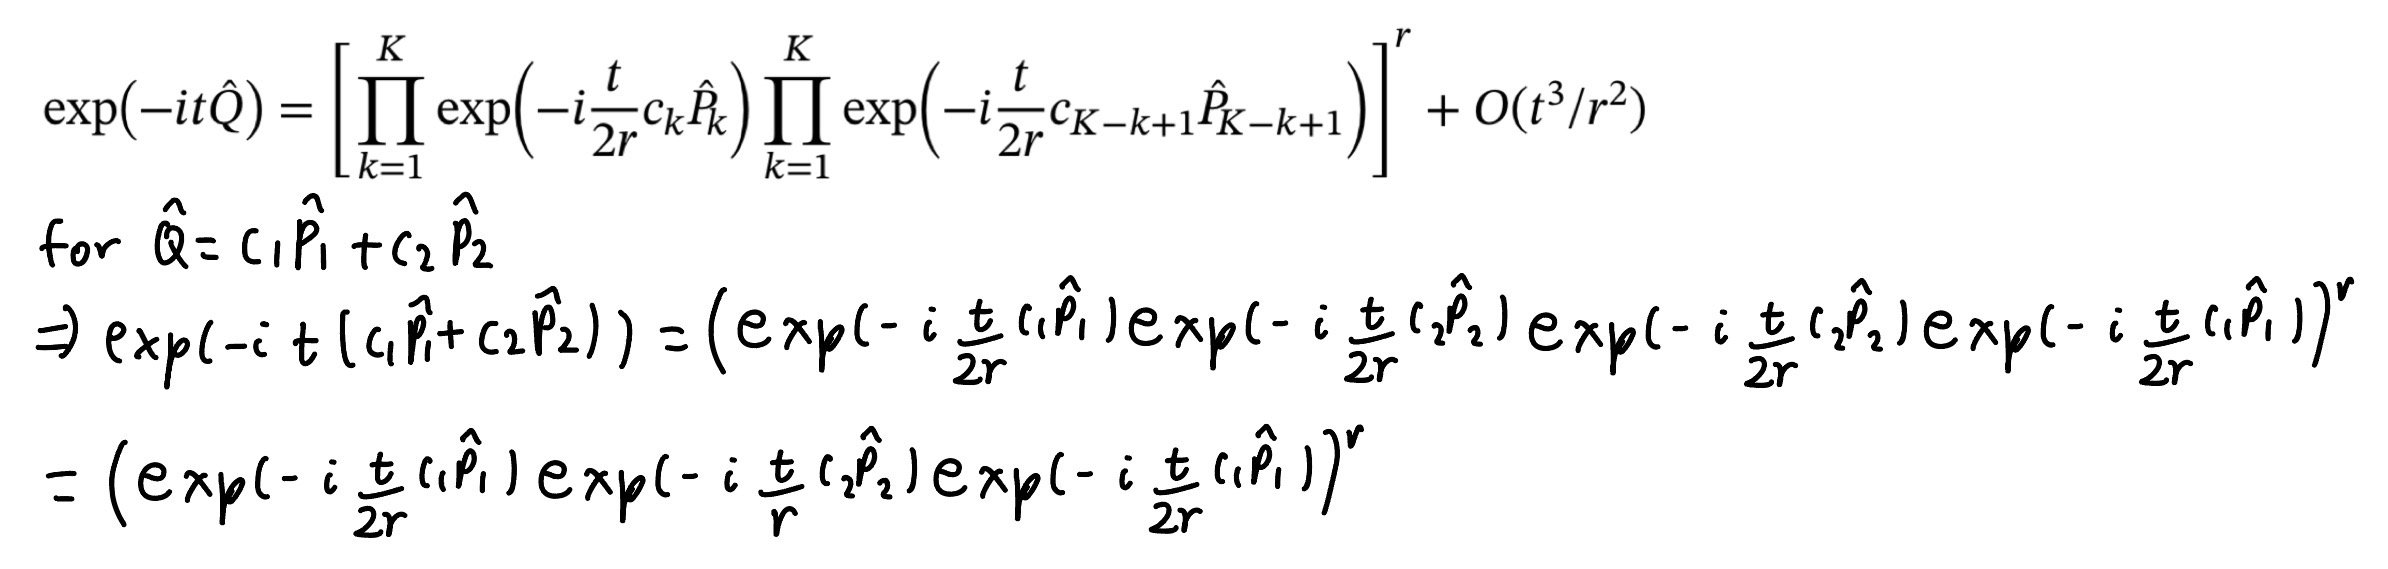

In [77]:
Image('3_4.jpg')

**(a)**

In [78]:
def trotter_first_order(Q, t, r, num_qubits):
    qc = QuantumCircuit(num_qubits)
    
    terms = []
    for term, coeff in Q.to_openfermion().terms.items():
        ps = PauliString(list(term))
        terms.append((coeff, ps))
        
    dt = t / r
    for _ in range(r):
        for ck, Pk in terms:
            qc.compose(exp_it(Pk, (dt * ck).real, num_qubits), inplace=True)
            # modify rather than new circuit
    return qc

def trotter_second_order(Q, t, r, num_qubits):
    qc = QuantumCircuit(num_qubits)
    terms = []
    for term, coeff in Q.to_openfermion().terms.items():
        ps = PauliString(list(term))
        terms.append((coeff, ps))
        
    dt = t / r

    for _ in range(r):
        for ck, Pk in terms:
            qc.compose(exp_it(Pk, (dt * ck/2).real, num_qubits), inplace=True)

        for ck, Pk in reversed(terms):
            qc.compose(exp_it(Pk, (dt * ck/2).real, num_qubits), inplace=True)

    return qc

**(b)**

Confirm whether the circuit from III.3 is correctly reproduced.

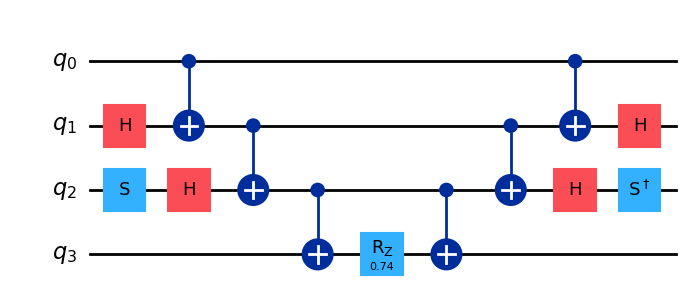

In [79]:
ps = PauliString([(0,"Z"),(1,"X"), (2,"Y"), (3,"Z")])
t = 0.37
qc=trotter_first_order(ps,t,1,4)
qc.draw("mpl")

Circuit as desired. Now confirm if second order is correct.

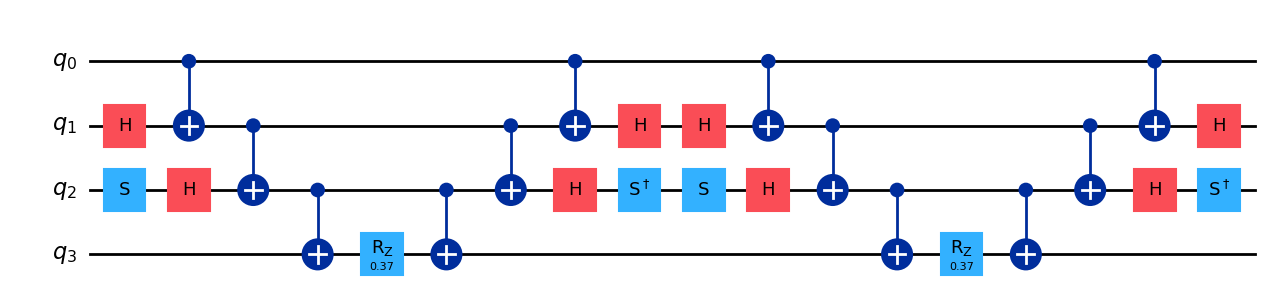

In [80]:
qc=trotter_second_order(ps,t,1,4)
qc.draw("mpl")

Circuit as desired.

H$_2$ molecule.

First Order:


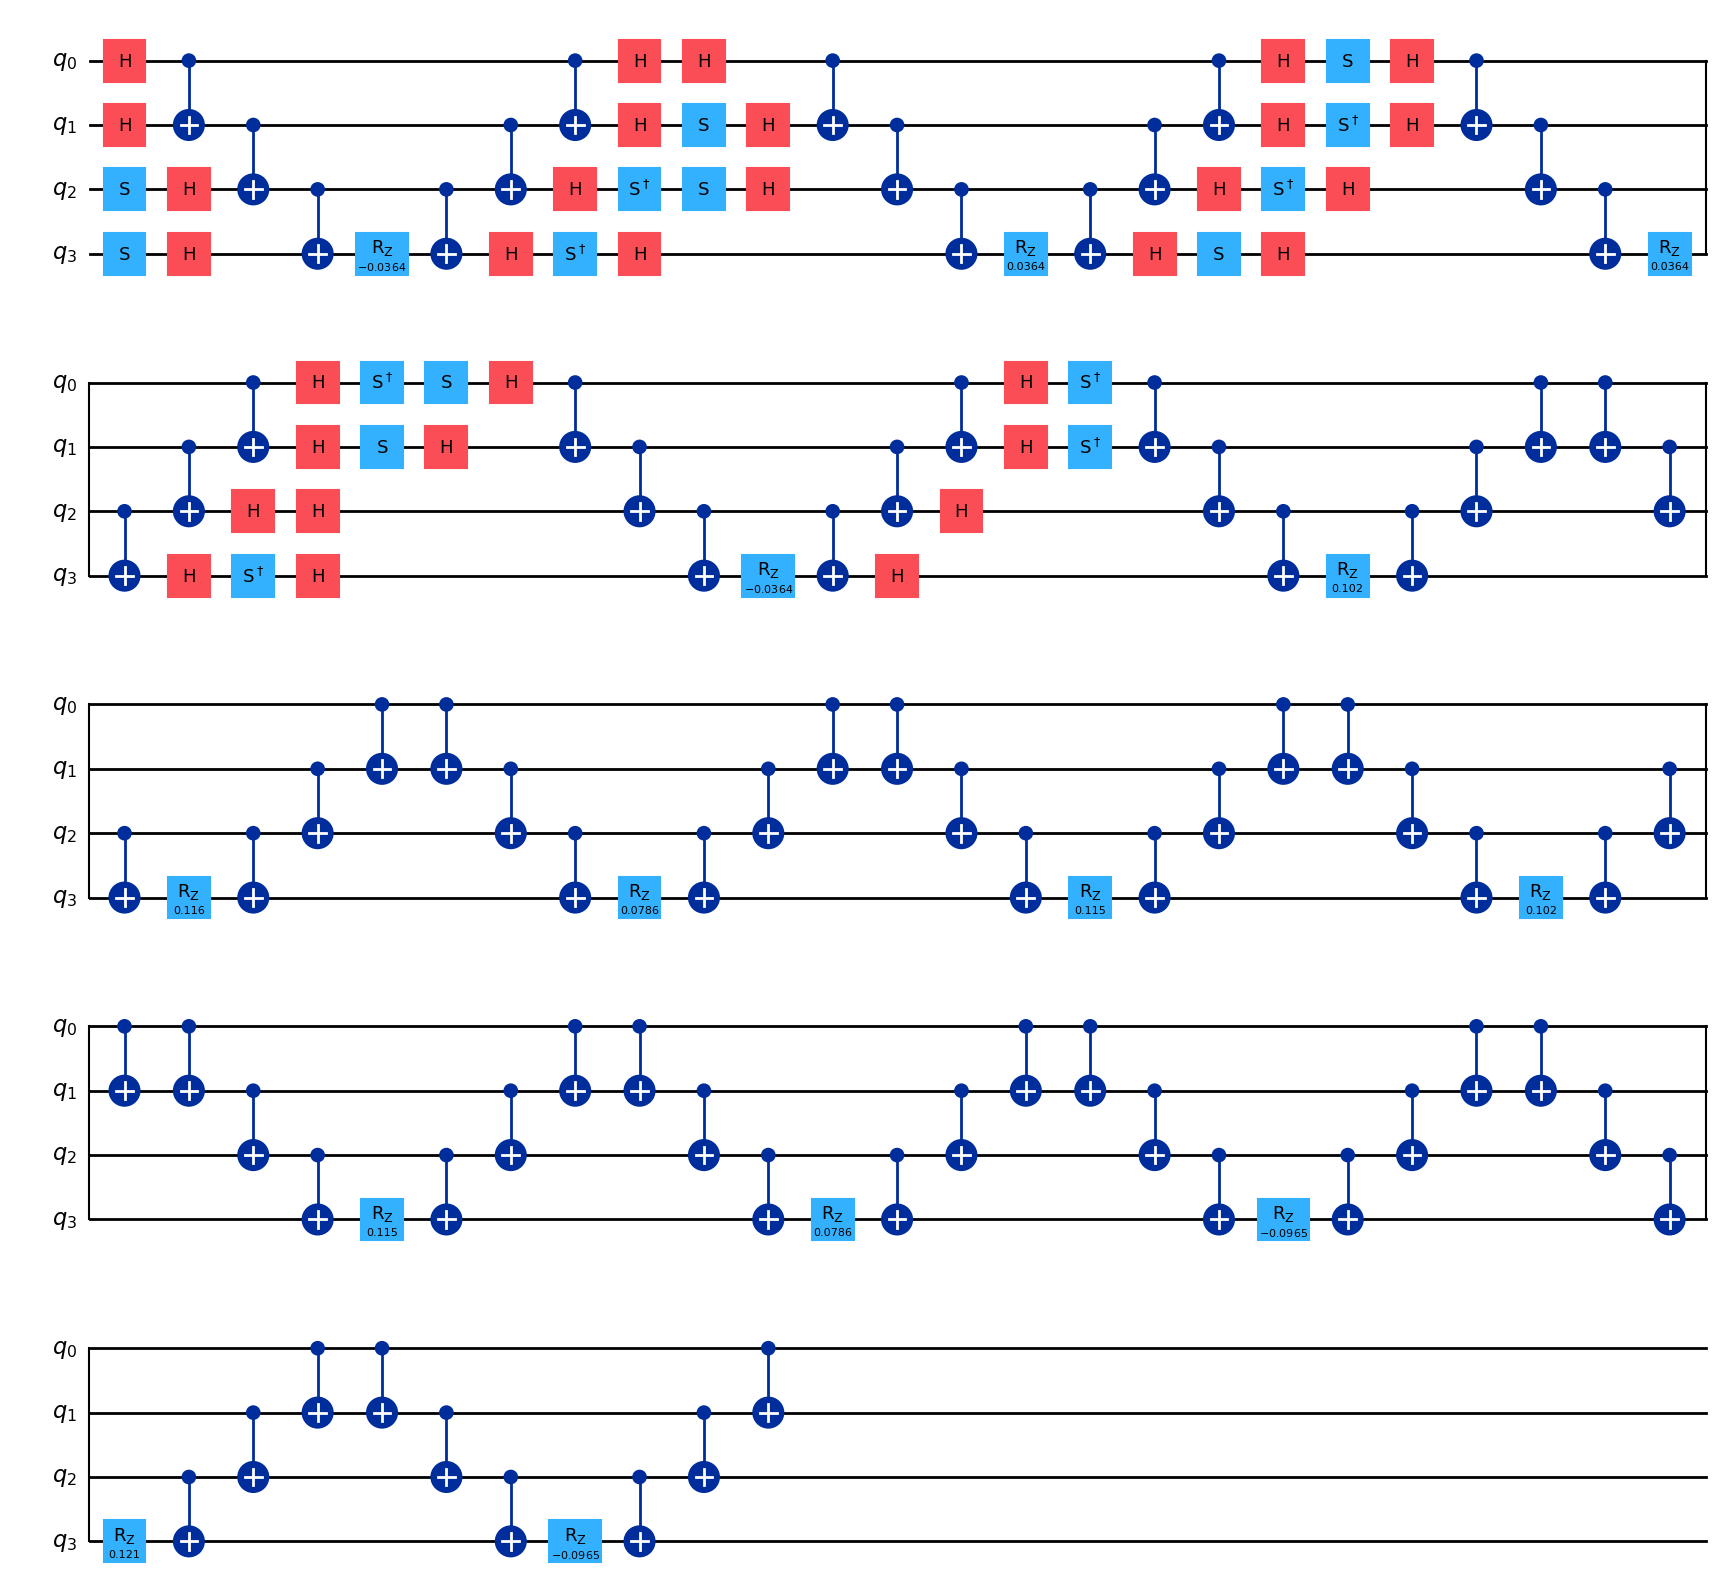

In [81]:
# H2 qubit Hamiltonian as your QubitOperator
H2_q = QubitOperator([
    (-0.049197645871367546, PauliString([(0,"X"),(1,"X"),(2,"Y"),(3,"Y")])),
    ( 0.049197645871367546, PauliString([(0,"X"),(1,"Y"),(2,"Y"),(3,"X")])),
    ( 0.049197645871367546, PauliString([(0,"Y"),(1,"X"),(2,"X"),(3,"Y")])),
    (-0.049197645871367546, PauliString([(0,"Y"),(1,"Y"),(2,"X"),(3,"X")])),
    ( 0.13716572937099492, PauliString([(0,"Z")])),
    ( 0.1566006248823794,  PauliString([(0,"Z"),(1,"Z")])),
    ( 0.10622904490856078, PauliString([(0,"Z"),(2,"Z")])),
    ( 0.15542669077992832, PauliString([(0,"Z"),(3,"Z")])),
    ( 0.13716572937099483, PauliString([(1,"Z")])),
    ( 0.15542669077992832, PauliString([(1,"Z"),(2,"Z")])),
    ( 0.10622904490856078, PauliString([(1,"Z"),(3,"Z")])),
    (-0.13036292057109045, PauliString([(2,"Z")])),
    ( 0.1632676867356434,  PauliString([(2,"Z"),(3,"Z")])),
    (-0.13036292057109042, PauliString([(3,"Z")])),
])

E0 = -0.32760818967481076

t = 0.37
r = 1
num_qubits = 4

qc_1st = trotter_first_order(H2_q, t, r, num_qubits)
qc_2nd = trotter_second_order(H2_q, t, r, num_qubits)
print("First Order:")
qc_1st.draw("mpl")

Second Order:


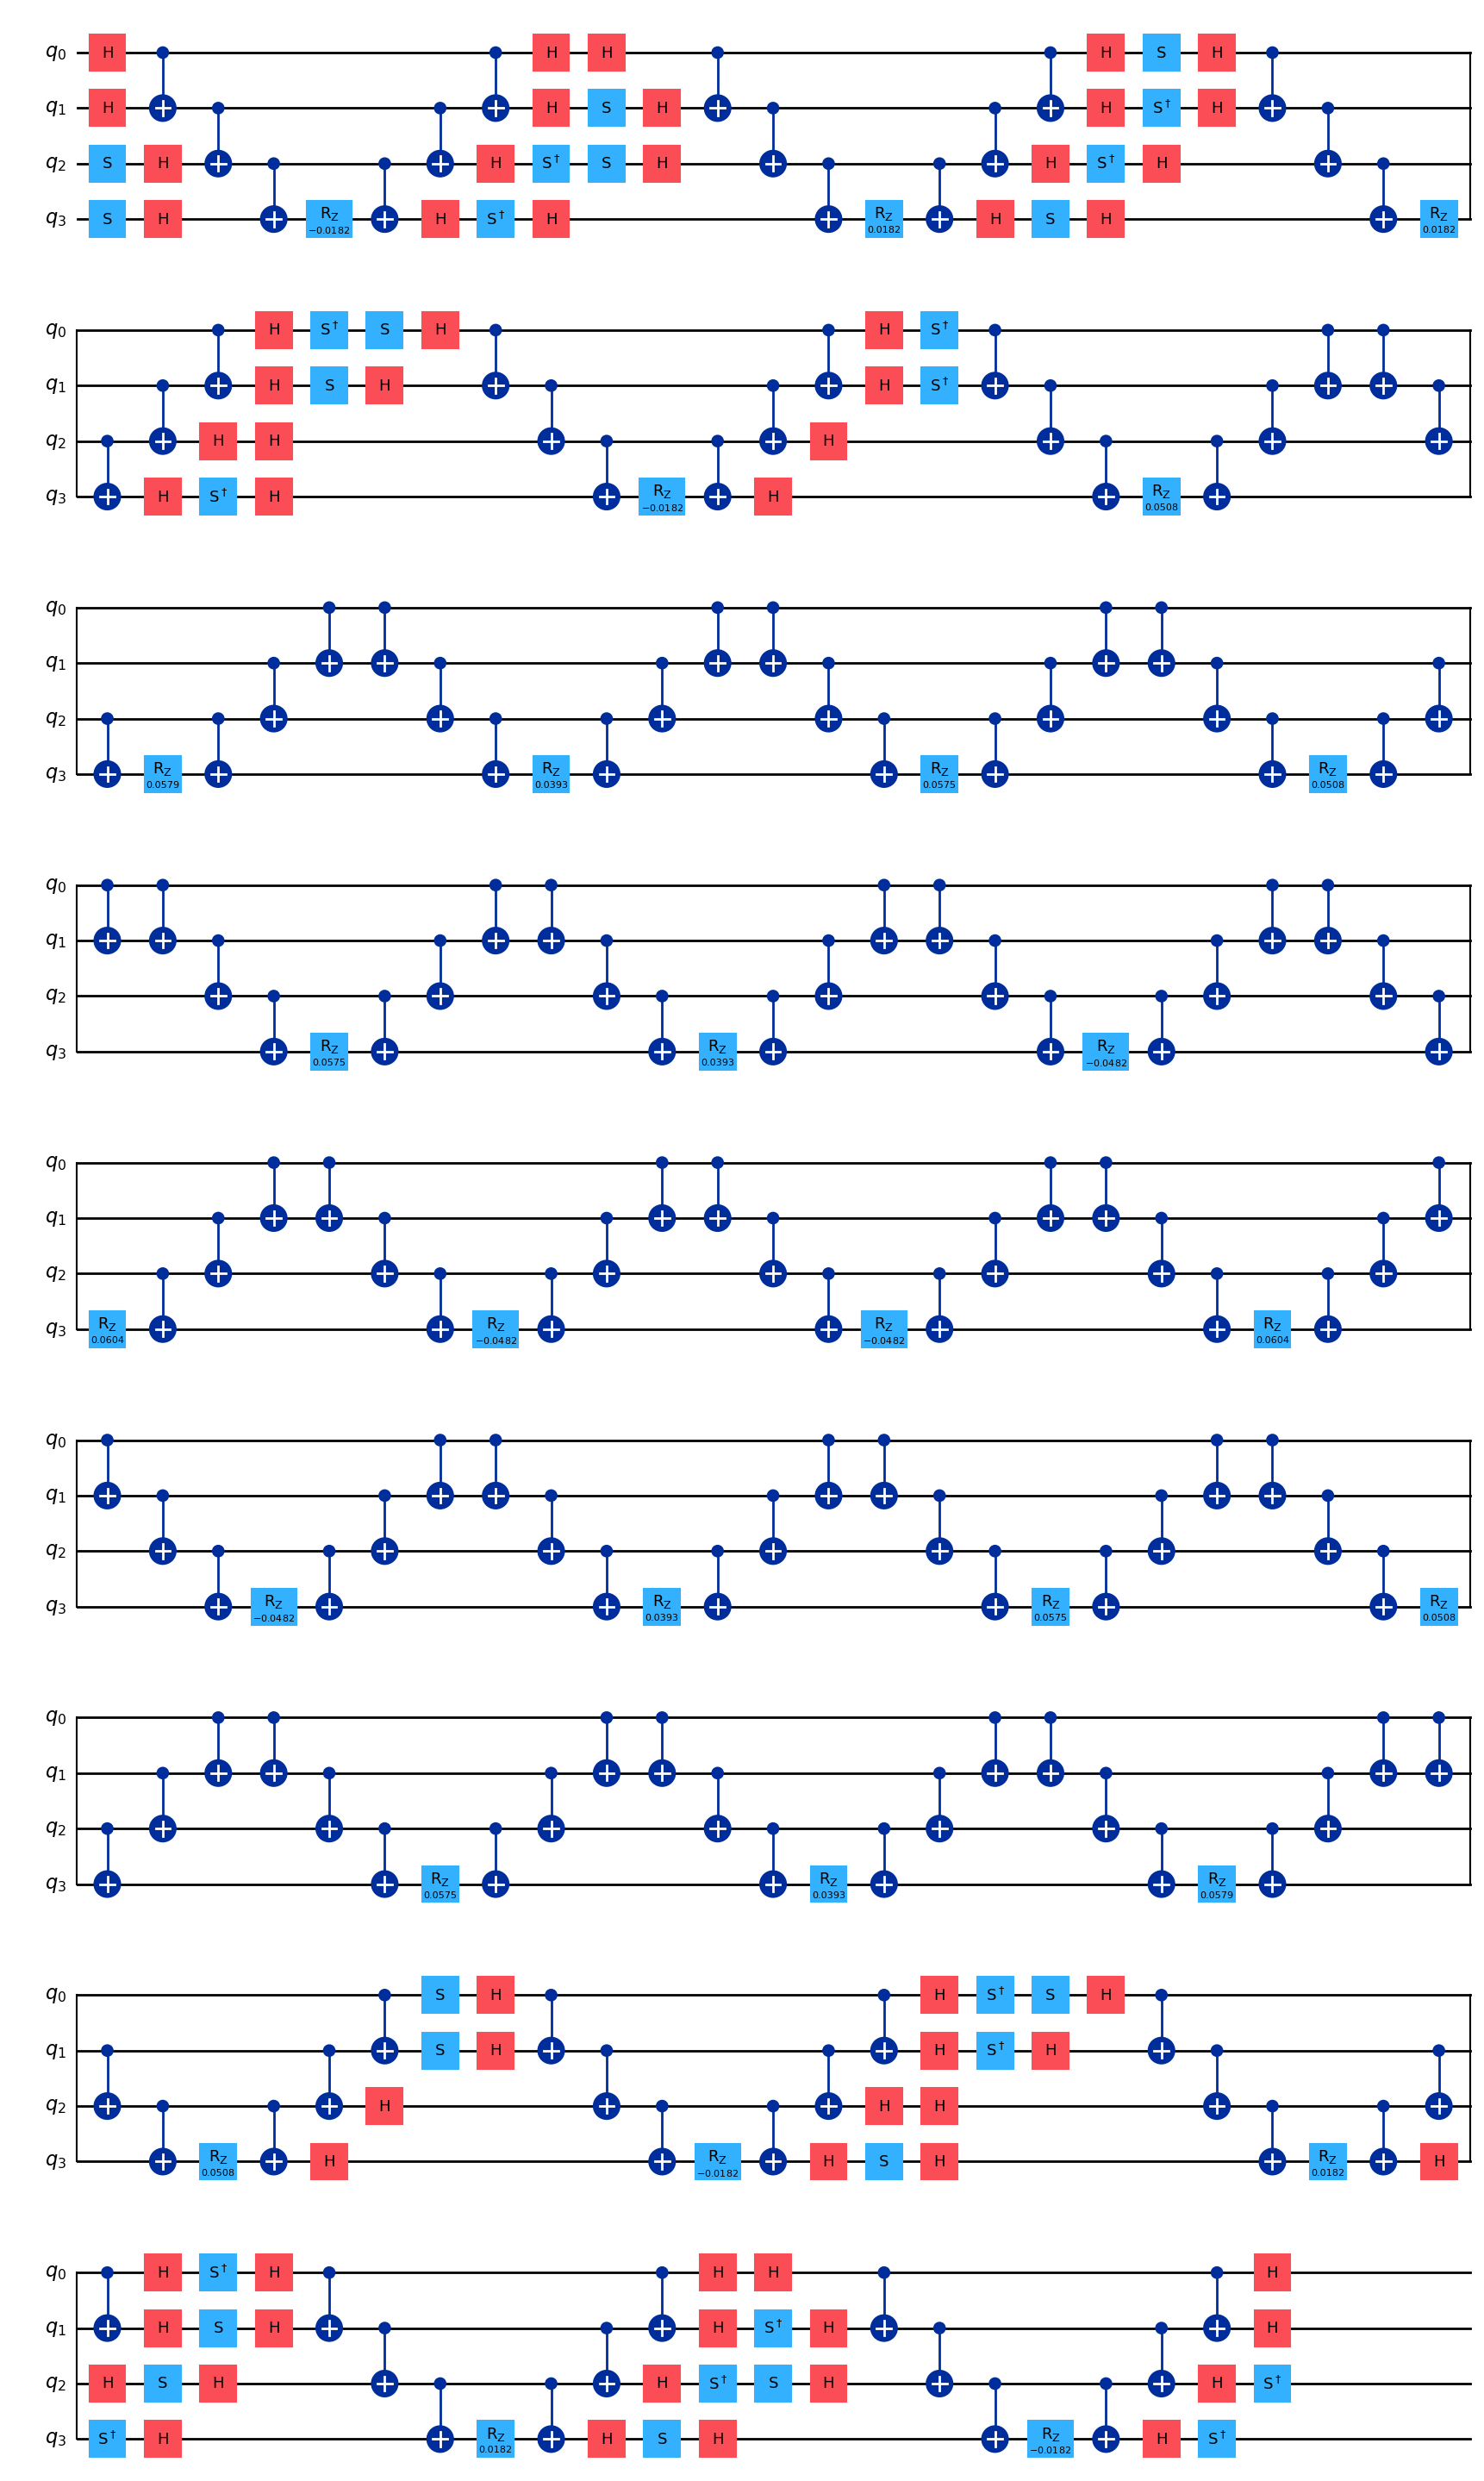

In [82]:
print("Second Order:")
qc_2nd.draw("mpl")

### Discussion Questions

*What is the maximum number of qubits that your computer can handle for state-
vector simulations? What aspects of your computer (e.g. CPUs or RAM) determine
this? How does this answer change if you change the numerical data type of
state-vector elements (e.g. single- or double-precision complex numbers)?*

Complex128 is double precision complex and uses 16 bytes per amplitude, and Complex64 is single precision complex and uses 8 bytes per amplitude [4]. My laptop has 24GB (~22.35 GiB) of ram which means with Complex128 I can use 30 qubits $\left(22.35\cdot2^{30}\approx2^{34.48}=16\cdot2^{30.48}\right)$, and with Complex64 I can use 31 qubits $\left(2^{34.48}=8\cdot2^{31.48}\right)$ [5].


*Can you give a bound for the depth of the circuit for $\text{exp}(−it\hat{P})$ in terms of the length of $\hat{P}$?*

Pauli of length $l$ ($l$ non-identity Paulis) has circuit depth that scales linearly in $l$. Parity compute uses $l-1$ CNOT layers, then one $R_z$, then $l-1$ layers to uncompute, worst case $Y$ basis change requires $4$ layers $\Rightarrow\text{depth}\leq2(l-1)+1+4=2l+3$.

*How does the depth of the circuit for $\text{exp}(−it\hat{P})$ vary with the Trotter number $r$?
What about the numerical errors arising from the Trotter–Suzuki decompositions?
Can you quantify this numerically for a simple $\hat{Q}$?*

For $\hat{Q}=\sum_{k=1}^Kc_k\hat{P}_k$, first order $\text{depth}\approx r\sum_{k=1}^K\text{depth}\left[\text{exp}(−i\frac{t}{r}c_k\hat{P}_k)\right]\approx r\sum_{k=1}^K(2l_k+3)$, and for second order, $\text{depth}\approx 2r\sum_{k=1}^K(2l_k+3)$.

Error scales as shown below, with example $\hat{Q}=\hat{X}_0+\hat{Z}_0$. Noting that if $A$ is Hermitian and has eigenvalue equation $Av_i=\lambda_i v_i$ then $A=V\Lambda V^\dagger$ with $\Lambda=\mathrm{diag}(\lambda_i)$, and $V=[v_1\cdots v_n]$ (for $n$ eigenvectors). This means that $e^{-itA}=e^{-itV\Lambda V^\dagger}=Ve^{-it\Lambda}V^\dagger=V\mathrm{diag}\left(e^{-it\lambda_i}\right)V^\dagger$ (as $V^\dagger V=I$, and $\Lambda$ is diagonal).

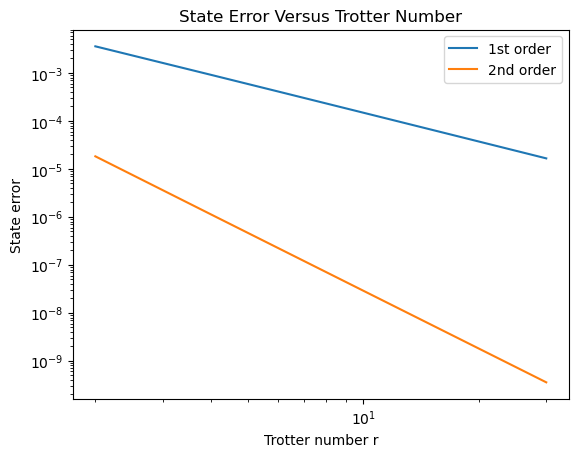

In [88]:
t = 0.37
rs = np.arange(2, 31, 2)
# exact
evals, evecs = np.linalg.eigh(X +Z)
Ue = evecs @ np.diag(np.exp(-1j * t* evals)) @ evecs.conj().T

# trotterization
Xps = PauliString([(0,"X")])
Zps = PauliString([(0,"Z")])
Q = QubitOperator([(1.0,Xps), (1.0,Zps)])


psi0 =Statevector.from_label("0")
#input state
err1, err2 = [], []
for r in rs:
    qc1 = trotter_first_order(Q, t,r,num_qubits=1)
    qc2 = trotter_second_order(Q, t,r,num_qubits=1)

    psi1 =psi0.evolve(qc1).data
    psi2 =psi0.evolve(qc2).data
    
    err1.append(1 -np.abs(np.vdot(Ue @ np.array([1,0],complex), psi1))**2)
    #Ue|0>, inner product of this with psi1
    err2.append(1 -np.abs(np.vdot(Ue @ np.array([1,0],complex), psi2))**2)

plt.loglog(rs, err1, label="1st order")
plt.loglog(rs, err2, label="2nd order")
plt.xlabel("Trotter number r")
plt.ylabel(r"State error")
plt.title("State Error Versus Trotter Number")
plt.legend()
plt.show()

### References

[1]    Young, David C. _Computational Chemistry: A Practical Guide for Applying Techniques to Real World Problems_. Wiley Interscience, 2001.

[2]    _PySCF: Quickstart_. PySCF.org. https://pyscf.org/quickstart.html. 

[3]    _OpenFermion-PySCF Demo_. Quantumlib. https://github.com/quantumlib/OpenFermion-PySCF/blob/main/examples/openfermionpyscf_demo.ipynb. 

[4]    _NumPy Data types_. NumPy Developers Documentation. https://numpy.org/devdocs/user/basics.types.html.

[5]    _Gibibyte (GiB)_. National Institute of Standards and Technology (NIST) Computer Security Resource Center Glossary. https://csrc.nist.gov/glossary/term/gibibyte